In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Not connected to a GPU
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
!pip install --upgrade -q jax jaxlib

import requests
import os
if 'TPU_DRIVER_MODE' not in globals():
  url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
  resp = requests.post(url)
  TPU_DRIVER_MODE = 1

# TPU driver as backend for JAX
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
print(config.FLAGS.jax_backend_target)

grpc://10.74.102.66:8470


In [ ]:
import os, sys

import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
mpl.style.use('default')

import torch
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", False) # otherwise fails to compute cholesky due to bad correlation matrix precision
config.update("jax_debug_nans", True)


import os
# more than 50% is not needed for Tesla P100
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.40'
#os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.50'


# on tesla P100 the speed of samping is much much faster

#CPUs parallelization
import multiprocessing
max_thread_numbers=multiprocessing.cpu_count()
import os
#os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=%d"%(max_thread_numbers)



import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)


FS = 18 # fontsize


!pip install einops --quiet

In [ ]:
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [ ]:
jax.default_device() 

# Dataset

In [ ]:
import torch.multiprocessing as multiprocessing
multiprocessing.set_start_method('spawn')

## Labels

Would be nice

It has been reported that the PSD of a quasar decreases with respect to Damped random walk on the scale less than month. Formally the break time scales were found to be less than 53 days. We assume that the breaks happen on the scales less than two month, so maximal relevant $\rho_{max} \sim \frac{60}{2\pi} \sim 10 \ days$ 
(https://iopscience.iop.org/article/10.3847/1538-4357/aab88d/pdf)


We consider a minimal cadence of a day, so the lowest frequency is $1/2 \ days^-1$, so the lowers relevant $\rho_{min} = \sqrt{3} \cdot 2/ (2\pi) \approx 0.55 \ days$  

 
(https://iopscience.iop.org/article/10.1088/0004-637X/698/1/895#apj299016t2).


In the same time, considering the relevant correlation time that do not result in somewhat a white noise, we found that the least relevant value is $\tau = 10^{1.68} \approx 47 \ days$. We pick it as a lower bound  $log(\tau)_{min} = 1.68$. They report that median relaxation time is 540 days, whereas dispersion corrected for uncertainties is 0.3 dex.

We sample up to +4 sigma which corresponds to $\tau = 10^{3.93} \ days$. This will be the upper bound on the correlation tim $log(\tau)_{max} = 3.93$. Moreover, we will sample $\frac{10^{3.93}}{365} * 2\pi \approx 145 \ years$ to ensure presence of all the necessary frequencies in Damped Random Walk spectrum. 

Therefore, we will sample $\rho \sim \mathcal{U}(0.55,10)$, $log(\tau) \sim \mathcal{N}_{trunc}(\mu = 2.73, \sigma = 0.3, lb = 1.68, ub = 3.93)$

In reality.


All the $\rho$ info is relevant, however, if we observe 10 years, $tau=580 \ days$ already results in fact into red noise instead of DRW, therefore it doesn't make any sense to sample more.


In [ ]:
def relevant_spectral_times(Duration,grid_step):

  frequencies = scipy.fft.rfftfreq(int(Duration // grid_step),grid_step)

  max_tau = 1/np.sqrt(3)/(2*np.pi*frequencies[1])

  min_rho = np.sqrt(3)/(2*np.pi*frequencies[-1])

  return max_tau,min_rho

In [ ]:
tau_rng = np.random.default_rng(78)
rho_rng = np.random.default_rng(18)

rho_bounds = np.array([0.55,10])
#log_tau_bounds = np.array([1.68,3.93])
#log_tau_params = np.array([2.73,0.3])
log_tau_bounds = np.array([1.05,2.76]) # from 10 days (third minimal in the paper, to 580 days, which is red noise for 10 years)

rho_distribution=scipy.stats.uniform(rho_bounds[0],rho_bounds[1]-rho_bounds[0])
#log_tau_distribution = scipy.stats.truncnorm(*(log_tau_bounds-log_tau_params[0])/log_tau_params[1],*log_tau_params)
log_tau_distribution = scipy.stats.uniform(log_tau_bounds[0],log_tau_bounds[1]-log_tau_bounds[0])

num_labels = 300000
rho_samples = rho_distribution.rvs(size=num_labels,random_state=rho_rng)
log_tau_samples = log_tau_distribution.rvs(size=num_labels,random_state=tau_rng)

labels_data = np.array([np.power(10, log_tau_samples),rho_samples]).T

duration = 10
# additionally sample 10 years for saturation

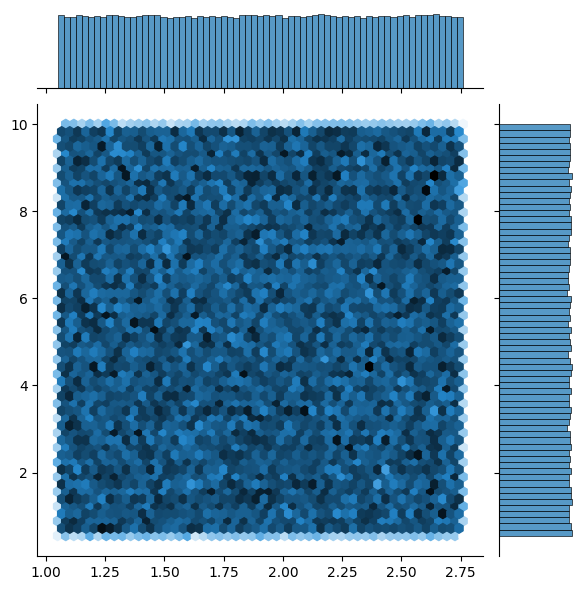

In [ ]:
sns.jointplot(x=log_tau_samples,y=rho_samples,kind='hex')

## RDRW Dataset class

In [ ]:
from functools import partial

@jax.jit
def split_six_keys(key):
  return jax.random.split(key,6)

class RDRW():

    def __init__(self,softening=1e-10,diagonal_softening=1e-8):

        self.softening = softening
        self.diagonal_softening = diagonal_softening


    def Power_spectrum(self,frequencies,Correlation_time,Reverberation_time,Variance = 1.,grid_step=1.):

        Normalisation = Variance**2 * (Correlation_time + Reverberation_time) /grid_step

        omega = 2* np.pi* frequencies

        Tau_factor = (1+omega**2 * Correlation_time**2)
        Rho_factor = (1+omega**2 * Reverberation_time**2)

        return Normalisation/Tau_factor/Rho_factor + self.diagonal_softening


    def RDRW_covariance(self,abs_time_difference, Correlation_time, Reverberation_time, Variance = 1.):

        Tau_ratio =  abs_time_difference / Correlation_time
        Rho_ratio = abs_time_difference / (Reverberation_time + self.softening)

        # caps of exponential factors to facilitate Cholesky decomposition
        #Tau_dependence = (Tau_ratio< -np.log(self.softening)) * jnp.exp(-Tau_ratio)
        #Rho_dependence = (Rho_ratio< -np.log(self.softening)) * jnp.exp(-Rho_ratio)

        Tau_dependence = jnp.exp(-Tau_ratio)
        Rho_dependence = jnp.exp(-Rho_ratio)

        Normalisation = 1. / (Correlation_time  - Reverberation_time)

        Time_dependence = Correlation_time * Tau_dependence - Reverberation_time * Rho_dependence

        return Variance*Normalisation * Time_dependence


    def conditional_distribution(self,desired_times,time_array, values_array,
            Correlation_time, Reverberation_time, Variance = 1., Mean = 0.):

        time_difference = desired_times[None,:] - time_array[:,None]

        Mutual_Correlations = self.RDRW_covariance(jnp.abs(time_difference),Correlation_time,Reverberation_time)

        Reference_Corr_matrix = self.RDRW_covariance(jnp.abs(time_array[None,:] - time_array[:,None]),Correlation_time,Reverberation_time)   + np.eye(len(time_array)) * self.diagonal_softening

        Reference_Cholesky = jax.scipy.linalg.cholesky(Reference_Corr_matrix, lower=True, overwrite_a=True)

        # Mean prediction
        alpha = jax.scipy.linalg.cho_solve((Reference_Cholesky, True), values_array)

        conditional_Mean = Mean + Mutual_Correlations.T @ alpha
        # f = self.mu + k.T @ self.inv_K @ (self.y-self.mu*one)

        Mutual_Corr_matrix = jax.scipy.linalg.solve_triangular(Reference_Cholesky,Mutual_Correlations,lower=True,check_finite=False)

        desired_time_difference = desired_times[None,:] - desired_times[:,None]
        self_Correlation_matrix = self.RDRW_covariance(jnp.abs(desired_time_difference),Correlation_time,Reverberation_time)

        conditional_Covariance_matrix = Variance * (self_Correlation_matrix -  Mutual_Corr_matrix.T @ Mutual_Corr_matrix)

        return conditional_Mean,conditional_Covariance_matrix

class RDRW_simulator(RDRW):

    def __init__(self,duration = 10, Saturation_time=10, grid_step = 4, random_seed = 7, softening=1e-10,diagonal_softening=1e-6):
        super().__init__(softening,diagonal_softening)

        if Saturation_time is None:
          # so we have a frequency on duration time
          Saturation_time = duration

        # Saturation is 22 years because above it would be just a random walk np.power(10,3.2)/365*2*np.pi

        self.duration = duration
        self.Saturation_time = Saturation_time

        
        self.length = 2*round((duration+Saturation_time)*365/grid_step/2)
        self.grid_step = grid_step/365

        self.frequencies = np.fft.rfftfreq(self.length,grid_step/365)
        self.grid = np.arange(0,self.length)*grid_step/365
        self.Saturation_offset = 2*round((Saturation_time)*365/grid_step/2)

        self.rng_key = jax.random.PRNGKey(random_seed)

        self.cadence_logits, self.mean_cadence = self.cadence_params()
        # 1.1 to enure that it reaches 5 years
        self._time_size = round(duration*365 / self.mean_cadence)

        self.simulator = self.get_simulator()


    def cadence_params(self,Day_amplitude = 0.7338, Poisson_scale = 4):
        # default values from high cadence observations in cosmograil dataset

        def cadence_pdf(x,A,const):
            return A*np.exp(-(x-1)/Poisson_scale)+const*(x==1)

        cadences = np.arange(1,25)
        probabilities = cadence_pdf(cadences,*[1.,Day_amplitude])
        probabilities/=probabilities.sum()

        logits = np.log(probabilities)

        math_expectation = (cadences*probabilities).sum()

        return logits,math_expectation

    def simulate_observation_times(self,key_cadence,key_night_times):

        exponential_cadences = jax.random.categorical(key_cadence, self.cadence_logits,
                                          shape=(self._time_size,))

        # to not overfit global shift
        start_point = exponential_cadences[0]
        # 1 day + possible poisson gaps
        cadences = 1+exponential_cadences[1:]

        # variation of obs time within night
        #night_times = jnp.clip(jax.random.laplace(key_night_times,shape=(self._time_size,)) * 0.055,-0.4,0.4)
        night_times = jax.random.uniform(key_night_times,shape=(self._time_size,),minval=-5/24,maxval=5/24)
        time_array = start_point + jnp.append(np.zeros(1),jnp.cumsum(cadences)) + night_times

        return time_array / 365

    def simulate_GP_on_regular_grid(self,Correlation_time,Reverberation_time,rng_key_magnitude):

        power = self.Power_spectrum(self.frequencies[1:],Correlation_time,Reverberation_time,grid_step=self.grid_step)

        noise = jax.random.normal(rng_key_magnitude,shape=(self.length,)).reshape(2,-1)
        phases = (noise*np.array([1.+0j,0.+1j])[:,None]).sum(axis=0)

        Fourier_image = jnp.append(np.zeros(1),jnp.sqrt(power)*phases)

        return jnp.fft.irfft(Fourier_image,norm='ortho')

    def simulate_GP_on_irregular_grid(self,Correlation_time,Reverberation_time,rng_key_regular_magnitude, rng_key_irregular_magnitude , rng_key_cadence, rng_key_night):

        regular_GP = self.simulate_GP_on_regular_grid(Correlation_time,Reverberation_time,rng_key_regular_magnitude)

        irregular_time_array = self.simulate_observation_times(rng_key_cadence,rng_key_night)

        local_grid = (self.grid - self.Saturation_time)[self.Saturation_offset:]
        local_regular_GP = regular_GP[self.Saturation_offset:]
        irregular_Mean, irregular_Covariance_matrix = self.conditional_distribution(irregular_time_array,local_grid,local_regular_GP,Correlation_time,Reverberation_time)

        irregular_Cholesky = jax.scipy.linalg.cholesky(irregular_Covariance_matrix + np.eye(self._time_size) * self.diagonal_softening, lower=True, overwrite_a=True)

        noise = jax.random.normal(rng_key_irregular_magnitude,shape=(self._time_size,))

        irregular_GP = irregular_Mean + irregular_Cholesky @ noise

        return irregular_time_array,irregular_GP,irregular_Mean,irregular_Covariance_matrix,regular_GP

    def sample_gaps(self,key_width,key_shift,shape):
        duration_params = np.array([135,25])
        duration_bounds = np.array([80,220])
        duration_normalised_bounds = (duration_bounds - duration_params[0])/duration_params[1]
        widths = jax.random.truncated_normal(key_width,*duration_normalised_bounds,shape=shape)*duration_params[1]+duration_params[0]

        middle_shifts_scale = 12
        middle_shifts_bounds = np.array([-20,20])
        middle_shifts_normalised_bounds = middle_shifts_bounds/middle_shifts_scale
        middle_shifts = jax.random.truncated_normal(key_shift,*middle_shifts_normalised_bounds,shape=shape)*middle_shifts_scale

        return middle_shifts,widths

    def sample_nogaps_masks(self,time_array,key_width,key_shift):

        gap_middle_shifts,gaps_widths = self.sample_gaps(key_width,key_shift,(self.duration+1,))

        # gap middle shift for selected year and
        gaps_starts = (gap_middle_shifts - gaps_widths/2)/365 + np.arange(self.duration+1)
        gaps_ends = (gap_middle_shifts + gaps_widths/2)/365 + np.arange(self.duration+1)

        nogaps_masks = (time_array[None,:] > gaps_ends[:-1,None]) & (time_array[None,:] < gaps_starts[1:,None])

        return  nogaps_masks.sum(0).astype(bool)

    def sample_irregular_time_mag_mask(self,Correlation_time,Reverberation_time,
                             rng_key_regular_magnitude, rng_key_irregular_magnitude ,
                             rng_key_cadence, rng_key_night,
                             rng_gap_key_width,rng_gap_key_shift):


        regular_GP = self.simulate_GP_on_regular_grid(Correlation_time,Reverberation_time,rng_key_regular_magnitude)

        irregular_time_array = self.simulate_observation_times(rng_key_cadence,rng_key_night)

        nogaps_masks = self.sample_nogaps_masks(irregular_time_array,rng_gap_key_width,rng_gap_key_shift)

        local_grid = (self.grid - self.Saturation_time)[self.Saturation_offset:]
        local_regular_GP = regular_GP[self.Saturation_offset:]
        irregular_Mean, irregular_Covariance_matrix = self.conditional_distribution(irregular_time_array,local_grid,local_regular_GP,Correlation_time,Reverberation_time)

        irregular_Cholesky = jax.scipy.linalg.cholesky(irregular_Covariance_matrix + np.eye(self._time_size) * self.diagonal_softening, lower=True, overwrite_a=True)

        noise = jax.random.normal(rng_key_irregular_magnitude,shape=(self._time_size,))

        irregular_GP = irregular_Mean + irregular_Cholesky @ noise

        return irregular_time_array,irregular_GP,nogaps_masks

    def get_simulator(self):

      @partial(jax.jit)
      def simulator(Correlation_time,Reverberation_time,
                             rng_key):
        
        #self.rng_key, rng_key_regular_magnitude, rng_key_irregular_magnitude,rng_key_cadence, rng_key_night,rng_gap_key_width,rng_gap_key_shift= 
        #self.split_seven_keys(self.rng_key)
        rng_new_key, rng_key_regular_magnitude, rng_key_irregular_magnitude ,rng_key_cadence, rng_key_night, rng_gap_key_width,rng_gap_key_shift = jax.random.split(rng_key,7)

        return rng_new_key, self.sample_irregular_time_mag_mask(Correlation_time,Reverberation_time,
                             rng_key_regular_magnitude, rng_key_irregular_magnitude ,
                             rng_key_cadence, rng_key_night,
                             rng_gap_key_width,rng_gap_key_shift)

      return simulator


    @partial(jax.jit,static_argnums=(0,))
    def split_seven_keys(self,key):
        return jax.random.split(key,7)

    def sample_light_curve(self,Correlation_time,Reverberation_time):


        #self.rng_key, rng_key_regular_magnitude, rng_key_irregular_magnitude,rng_key_cadence, rng_key_night,rng_gap_key_width,rng_gap_key_shift= self.split_seven_keys(self.rng_key)

        self.rng_key, (time_array,magnitude,nogaps_masks) = self.simulator(Correlation_time/365,Reverberation_time/365,
                                                        self.rng_key)

        return np.array(time_array),np.array(magnitude),np.array(nogaps_masks)


In [ ]:
simulator = RDRW_simulator(grid_step=4,diagonal_softening=1e-4)

In [ ]:
jax.device_count()

2

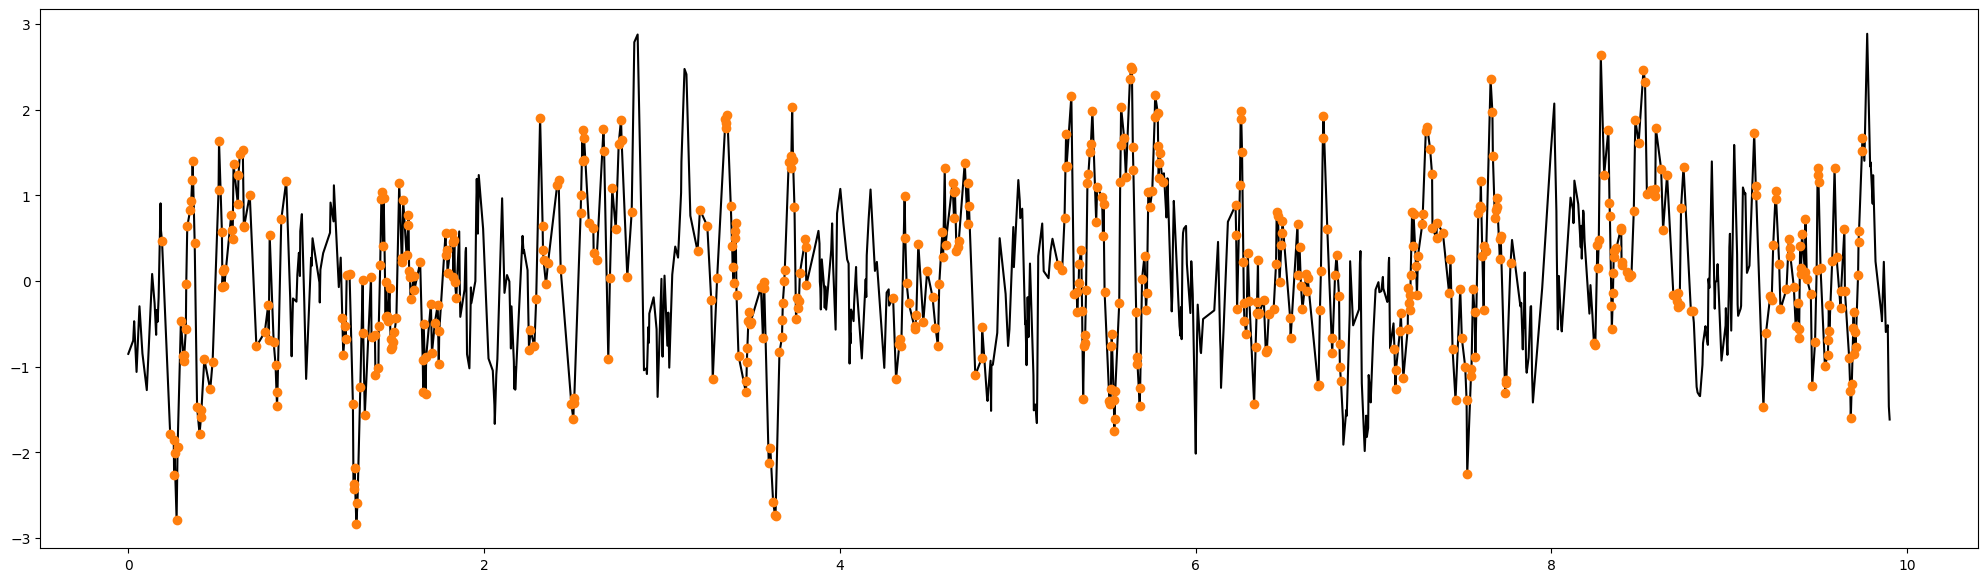

In [ ]:
simulator = RDRW_simulator(grid_step=4,diagonal_softening=1e-2)
time,magnitude,mask = simulator.sample_light_curve(*labels_data.min(axis=0))
fig,ax = plt.subplots(figsize=(25,7))
plt.plot(time,magnitude,color='k',zorder=0)
plt.scatter(time[mask],magnitude[mask],color='C1')

In [ ]:

time,magnitude,mask = simulator.sample_light_curve(*labels_data.max(axis=0))
fig,ax = plt.subplots(figsize=(25,7))
plt.plot(time,magnitude,color='k',zorder=0)
plt.scatter(time[mask],magnitude[mask],color='C1')

Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.


FloatingPointError: ignored

In [ ]:
1/0.7338/4

0.3406922867266285

In [ ]:
simulator = RDRW_simulator(grid_step=4)
time,magnitude,mask = simulator.sample_light_curve(*labels_data.min(axis=0))
fig,ax = plt.subplots(figsize=(25,7))
plt.plot(time,magnitude,color='k',zorder=0)
plt.scatter(time[mask],magnitude[mask],color='C1')

RuntimeError: ignored

In [ ]:
simulator = RDRW_simulator(grid_step=4)
time,magnitude,mask = simulator.sample_light_curve(*labels_data.min(axis=0))
fig,ax = plt.subplots(figsize=(25,7))
plt.plot(time,magnitude,color='k',zorder=0)
plt.scatter(time[mask],magnitude[mask],color='C1')

RuntimeError: ignored

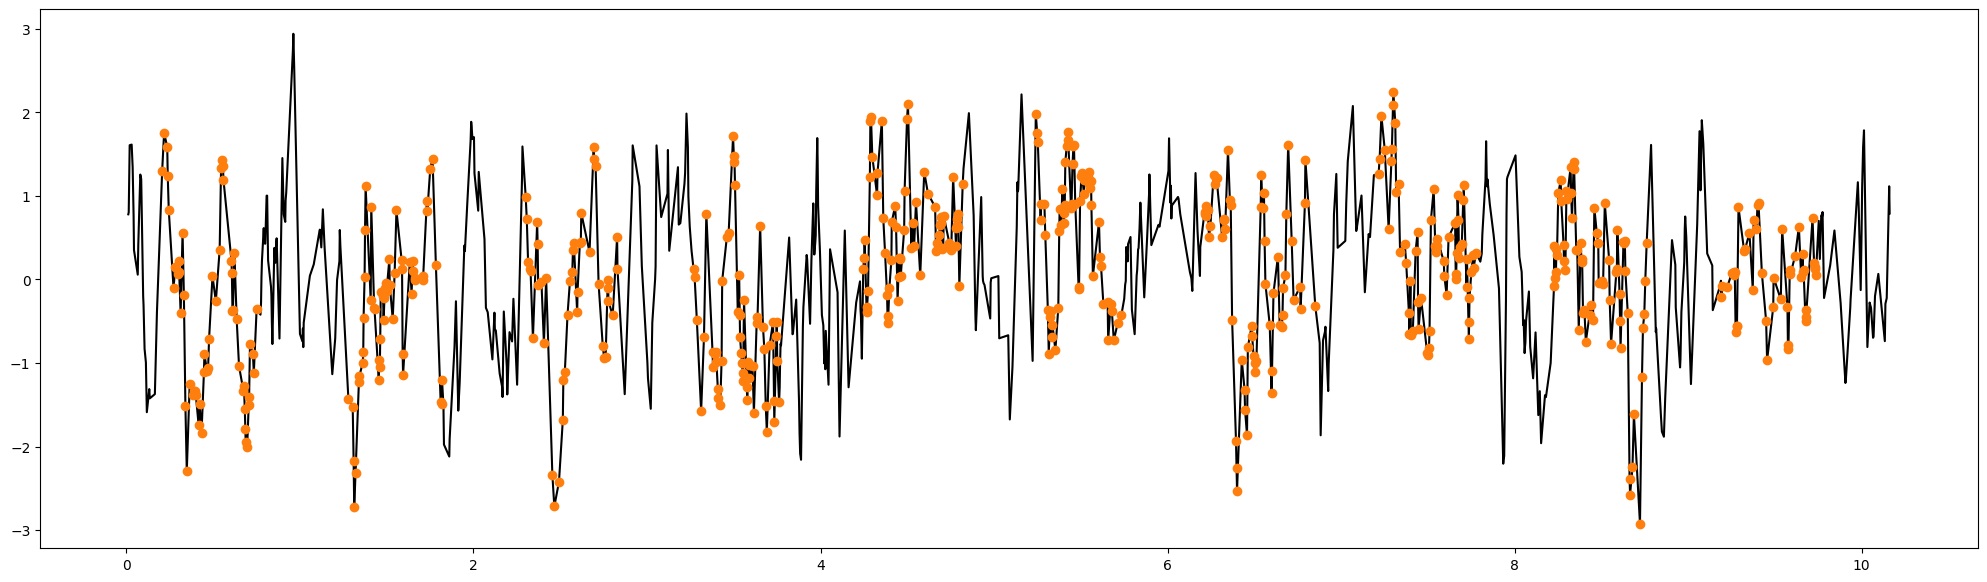

In [ ]:
simulator = RDRW_simulator(grid_step=4)
time,magnitude,mask = simulator.sample_light_curve(*labels_data.min(axis=0))
fig,ax = plt.subplots(figsize=(25,7))
plt.plot(time,magnitude,color='k',zorder=0)
plt.scatter(time[mask],magnitude[mask],color='C1')

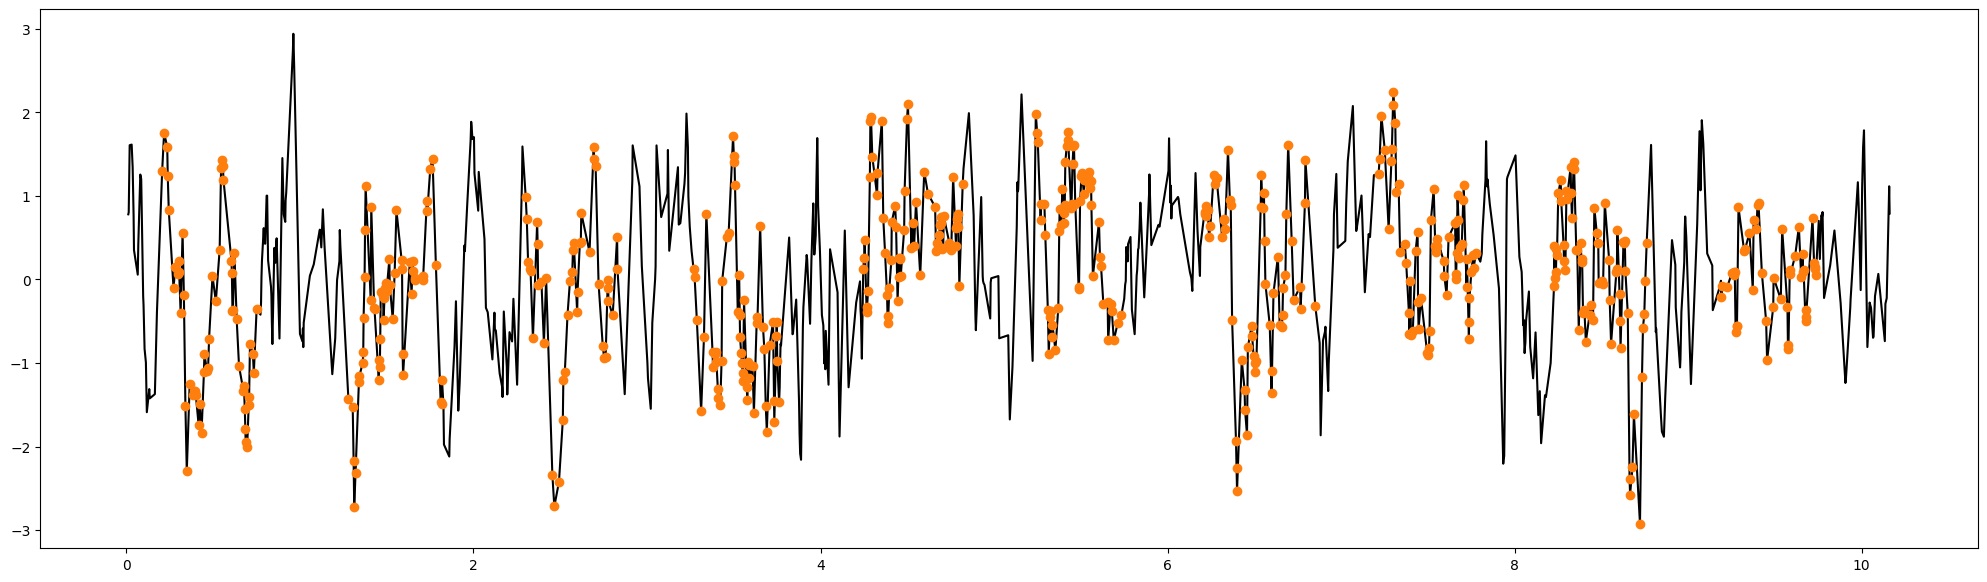

In [ ]:
simulator = RDRW_simulator(grid_step=4)
time,magnitude,mask = simulator.sample_light_curve(*labels_data.min(axis=0))
fig,ax = plt.subplots(figsize=(25,7))
plt.plot(time,magnitude,color='k',zorder=0)
plt.scatter(time[mask],magnitude[mask],color='C1')

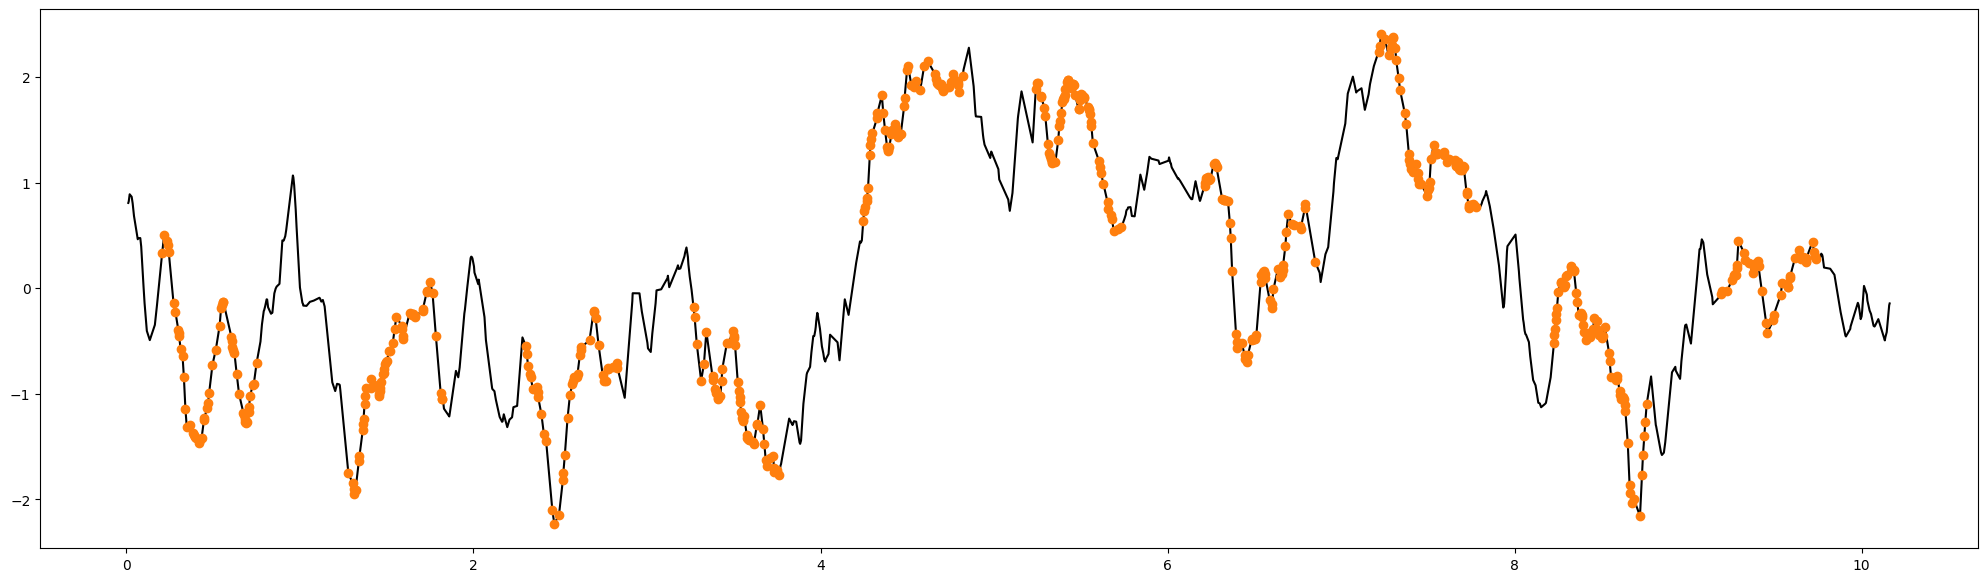

In [ ]:
simulator = RDRW_simulator(grid_step=4)
time,magnitude,mask = simulator.sample_light_curve(*labels_data.mean(axis=0))
fig,ax = plt.subplots(figsize=(25,7))
plt.plot(time,magnitude,color='k',zorder=0)
plt.scatter(time[mask],magnitude[mask],color='C1')

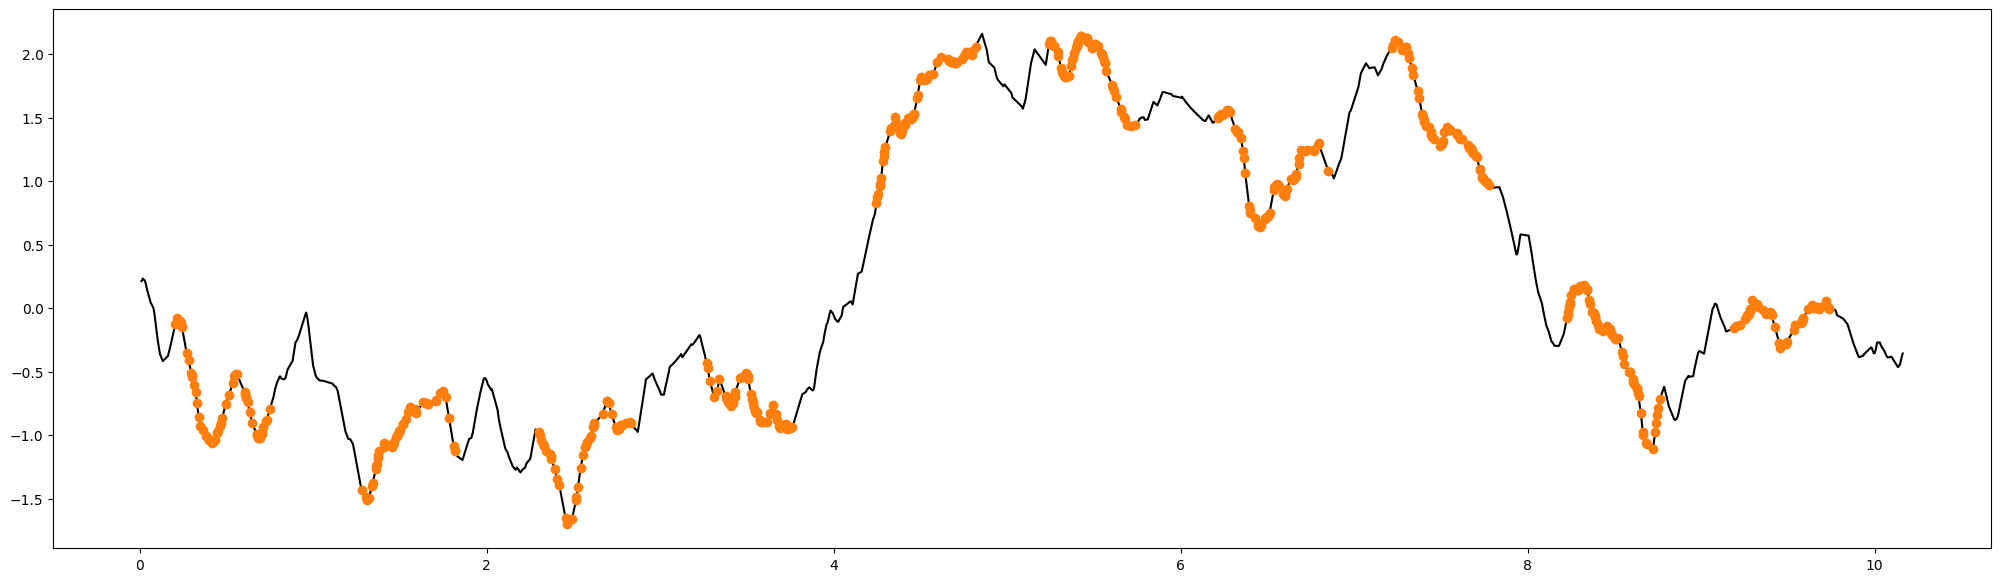

In [ ]:
simulator = RDRW_simulator(grid_step=4)
time,magnitude,mask = simulator.sample_light_curve(*labels_data.max(axis=0))
fig,ax = plt.subplots(figsize=(25,7))
plt.plot(time,magnitude,color='k',zorder=0)
plt.scatter(time[mask],magnitude[mask],color='C1')

## Observation dataset

In [ ]:
from torch.utils.data import Dataset
import numpy as np
from scipy.interpolate import BSpline
from typing import Union


class Normalise:

    def __init__(self, light_curve_target_max: float = 1., light_curve_target_min: float = -1.):

        assert light_curve_target_max > light_curve_target_min

        self._light_curve_target_max=light_curve_target_max
        self._light_curve_target_min=light_curve_target_min

    def light_curve_normalisation(self,curve_max,curve_min,target_max = None, target_min = None):


        if target_max is None:
            target_max = self._light_curve_target_max
        if target_min is None:
            target_min = self._light_curve_target_min


        curve_norm_factor= (target_max - target_min) / (curve_max - curve_min + 1e-10)
        curve_norm_shift= target_min - curve_min * curve_norm_factor

        return curve_norm_factor,curve_norm_shift

    def normalise_light_curve(self,light_curve: np.ndarray,curve_norm_factor = None, curve_norm_shift = None):

        if (curve_norm_factor is None) and (curve_norm_shift is None):
            curve_norm_factor, curve_norm_shift = self.light_curve_normalisation(np.max(light_curve),np.min(light_curve))

        normalised_light_curve= light_curve * curve_norm_factor + curve_norm_shift

        return normalised_light_curve

    def normalise_label(self, label: Union[np.ndarray,list], curve_norm_factor: float, curve_norm_shift: float, time_factor = None):


        if time_factor is None:
            time_factor = self._time_norm

        # Mean normalised according to Light_curve.
        # Corr_length and t_lambda normalised according to time_array
        # SF^2 ~ Variance/corr_time hence it transforms like curve_norm_factor**2/time_norm_factor
        #label_norm_factors = np.array([curve_norm_factor, (curve_norm_factor ** 2) * time_factor,
        #                               1. / time_factor, 1. / time_factor])
        # we assume that there is SF^2 in label[1]
        label_norm_factors = np.array([curve_norm_factor, curve_norm_factor ** 2,
                                       1. / time_factor, 1. / time_factor])
        label_norm_shifts= np.array([curve_norm_shift, 0., 0., 0.])
        normalised_label = label * label_norm_factors + label_norm_shifts

        return normalised_label


class Observations_RDRW(Dataset):

    def __init__(self, RDRW_simulator,labels: np.ndarray,light_curve_norm=(1, -1)):

        super().__init__()

        self.labels = labels

        self.RDRW_simulator = RDRW_simulator
        self.duration = self.RDRW_simulator.duration
        self.normalise_class = Normalise(*light_curve_norm)

    def normalise_magnitudes(self,observed,complete = None,labels = None):

        value_bounds = (np.max(observed), np.min(observed))
        value_normalisation = self.normalise_class.light_curve_normalisation(*value_bounds)

        normalised_observed =  self.normalise_class.normalise_light_curve(observed, *value_normalisation)

        if complete is None:
            normalised_complete = None
        else:
            normalised_complete = self.normalise_class.normalise_light_curve(complete, *value_normalisation)

        if labels is None:
            normalised_labels = None
        else:
            normalised_labels = self.normalise_class.normalise_label(labels, *value_normalisation,
                                                                     time_factor=1.)

        return normalised_observed,normalised_complete,normalised_labels

    def __len__(self):
      return len(self.labels)

    def get_item(self,label_index):

        labels = self.labels[label_index]

        time_array,magnitude_array,no_gaps_mask = self.RDRW_simulator.sample_light_curve(*labels)

        obs_time_array = time_array[no_gaps_mask]
        obs_magnitude_array = magnitude_array[no_gaps_mask]

        complete_labels = np.array([0, 1, *labels])
        obs_magnitude_array,magnitude_array,normalised_labels = self.normalise_magnitudes(obs_magnitude_array,magnitude_array,complete_labels)

        #log_labels = np.array([normalised_labels[0], *np.log10(normalised_labels[1:])])


        labels = np.array([np.log10(complete_labels[2]),complete_labels[3]])

        return obs_time_array,obs_magnitude_array,time_array,magnitude_array,labels


class Spline_Observations_RDRW(Observations_RDRW):

  def __init__(self, *args,**kwargs):

    super().__init__(*args,**kwargs)


    num_ref_points = 365
    step = 1 / num_ref_points
    self.query = np.linspace(step/2, 1 - step/2, num_ref_points,dtype=np.float32)
    self.full_query = np.repeat([self.query],self.duration,axis=0) + np.arange(self.duration)[:,None]

  def interpolate(self,time,light,padding='zeros'):

      spline_degree = 1
      spliner = BSpline(np.pad(time,(spline_degree,spline_degree),'edge'),
                         np.pad(light,(0,spline_degree+1),'edge'), spline_degree, extrapolate=False)
      spline = spliner(self.full_query)

      mask_left = self.full_query < time[0]
      mask_right =  self.full_query > time[-1]
      spline_masks = ~np.logical_or(mask_left,mask_right)

      spline[mask_left] = 0.
      spline[mask_right] = 0.

      return spline

  def normalise_magnitudes(self,observed):

      value_bounds = (np.max(observed), np.min(observed))
      value_normalisation = self.normalise_class.light_curve_normalisation(*value_bounds)

      normalised_observed =  self.normalise_class.normalise_light_curve(observed, *value_normalisation)

      return normalised_observed

  def get_item(self,label_index):

    labels = self.labels[label_index]

    time_array,magnitude_array,no_gaps_mask = self.RDRW_simulator.sample_light_curve(*labels)

    obs_time_array = time_array[no_gaps_mask]
    obs_magnitude_array = magnitude_array[no_gaps_mask]

    complete_labels = np.array([0, 1, *labels])
    obs_magnitude_array = self.normalise_magnitudes(obs_magnitude_array)

    #log_labels = np.array([normalised_labels[0], *np.log10(normalised_labels[1:])])

    context_splines = self.interpolate(obs_time_array,obs_magnitude_array)

    labels = np.array([np.log10(complete_labels[2]),complete_labels[3]])

    return context_splines,labels

  def __getitem__(self, index):
      item = self.get_item(index)
      return (*item,index)

  def _to_tensor(self, array,device = None):
      if device is None:
        device = self.device
      return torch.from_numpy(np.stack(array)).type(torch.float32).to(device)

  def collate_fn(self, batch):
      # meant to be redefined in subclasses for training purposes
      # this is an example of full use of functionality

      context_splines,labels,  idx = np.stack(batch, axis=1)

      #return [self._to_tensor(x) for x in [context_splines,out_labels,num_observed_years]]
      return [self._to_tensor(x,'cpu') for x in [context_splines,labels]]

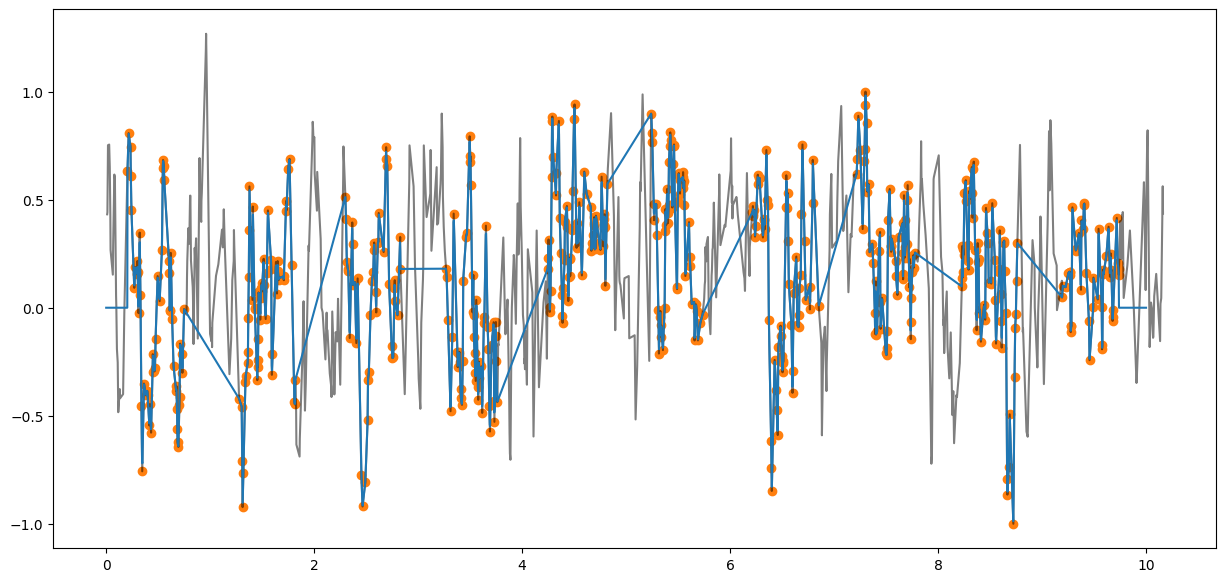

In [ ]:
simulator = RDRW_simulator(grid_step=4)

#tau = np.power(10,log_tau_bounds[0]); rho=np.power(10,log_rho_bounds[0])

tau,rho = labels_data.min(axis=0)
dataset = Observations_RDRW(simulator,labels = np.array([[tau,rho]]))
obs_time_array,obs_magnitude_array,time_array,magnitude_array, _ = dataset.get_item(0)
simulator = RDRW_simulator(grid_step=4)
dataset = Spline_Observations_RDRW(simulator,labels = np.array([[tau,rho]]))
splines,_ = dataset.get_item(0)
fig,ax = plt.subplots(figsize=(15,7))
plt.plot(time_array,magnitude_array,color='k',alpha=0.5)
plt.scatter(obs_time_array,obs_magnitude_array,color='C1')
plt.plot(dataset.full_query.flatten(),splines.flatten())

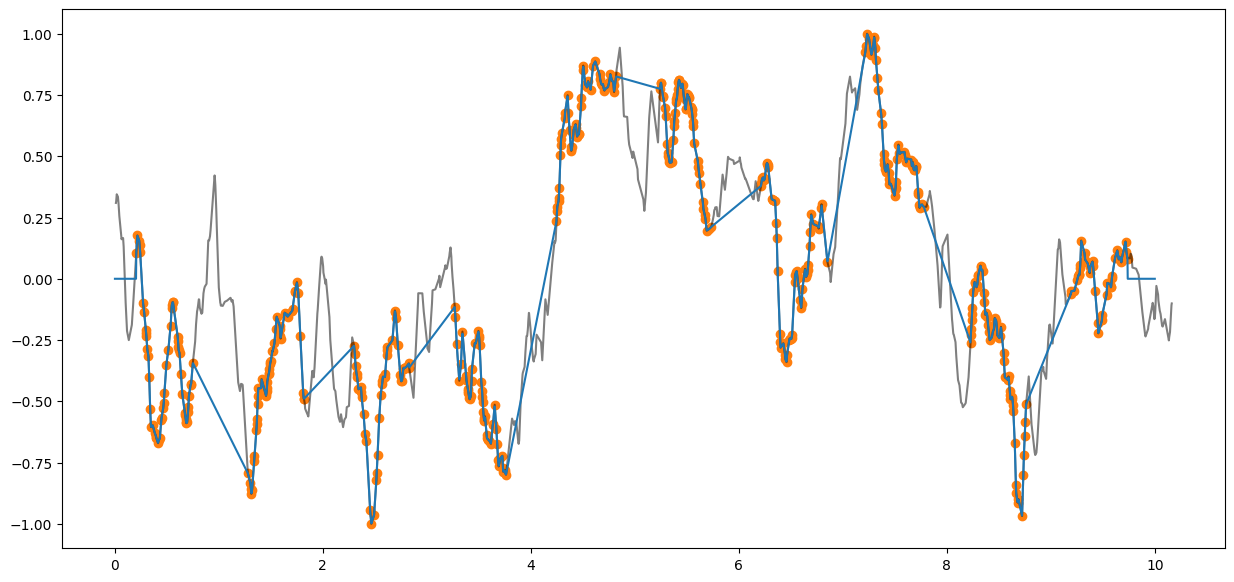

In [ ]:
simulator = RDRW_simulator(grid_step=4)

#tau = np.power(10,log_tau_bounds[0]); rho=np.power(10,log_rho_bounds[0])

tau,rho = labels_data.mean(axis=0)
dataset = Observations_RDRW(simulator,labels = np.array([[tau,rho]]))
obs_time_array,obs_magnitude_array,time_array,magnitude_array, _ = dataset.get_item(0)
simulator = RDRW_simulator(grid_step=4)
dataset = Spline_Observations_RDRW(simulator,labels = np.array([[tau,rho]]))
splines,_ = dataset.get_item(0)
fig,ax = plt.subplots(figsize=(15,7))
plt.plot(time_array,magnitude_array,color='k',alpha=0.5)
plt.scatter(obs_time_array,obs_magnitude_array,color='C1')
plt.plot(dataset.full_query.flatten(),splines.flatten())

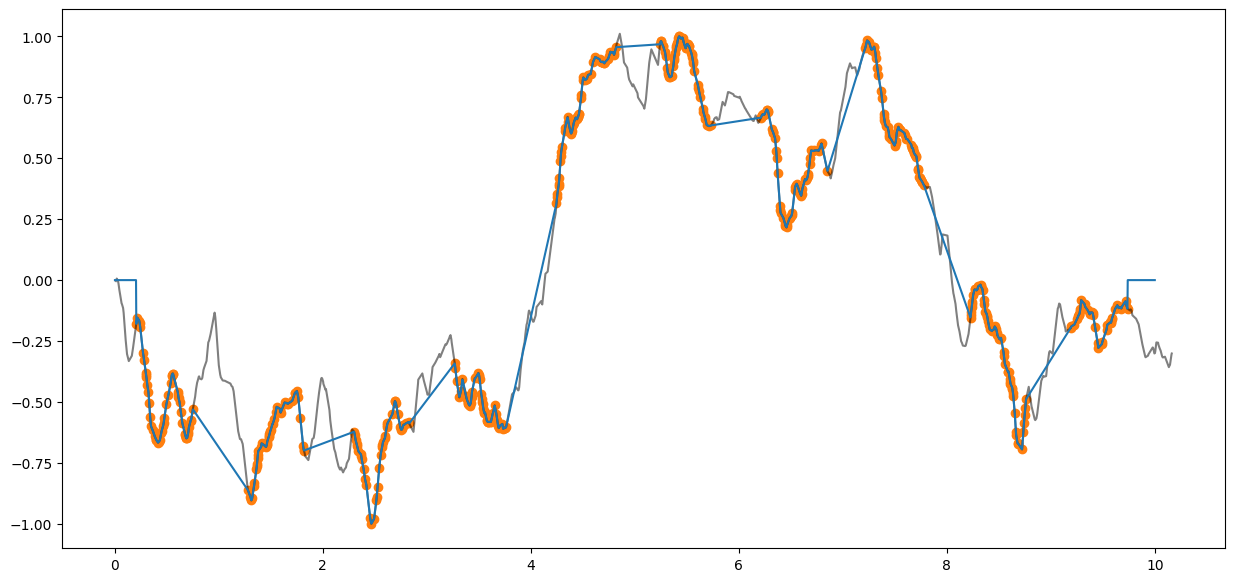

In [ ]:
simulator = RDRW_simulator(grid_step=4)

#tau = np.power(10,log_tau_bounds[0]); rho=np.power(10,log_rho_bounds[0])

tau,rho = labels_data.max(axis=0)
dataset = Observations_RDRW(simulator,labels = np.array([[tau,rho]]))
obs_time_array,obs_magnitude_array,time_array,magnitude_array, _ = dataset.get_item(0)
simulator = RDRW_simulator(grid_step=4)
dataset = Spline_Observations_RDRW(simulator,labels = np.array([[tau,rho]]))
splines,_ = dataset.get_item(0)
fig,ax = plt.subplots(figsize=(15,7))
plt.plot(time_array,magnitude_array,color='k',alpha=0.5)
plt.scatter(obs_time_array,obs_magnitude_array,color='C1')
plt.plot(dataset.full_query.flatten(),splines.flatten())

## Compile dataset

In [ ]:
from sklearn.model_selection import train_test_split
train_labels,val_labels = train_test_split(labels_data,test_size=0.2,random_state=42)
test_labels,val_labels = train_test_split(val_labels,test_size=0.5,random_state=24)
print(np.array([len(train_labels),len(val_labels),len(test_labels)])/num_labels)

[0.8 0.1 0.1]


In [ ]:
from torch.utils.data import DataLoader
batch_size = 128
num_workers=0

def get_dataloader(labels,random_seed = 7):
  
  simulator = RDRW_simulator(grid_step=4,random_seed=random_seed)
  dataset = Spline_Observations_RDRW(simulator,labels =labels,light_curve_norm=(1, -1))

  shuffle_generator = torch.Generator()
  shuffle_generator = shuffle_generator.manual_seed(random_seed*128)
  dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True,
    drop_last=True, collate_fn=dataset.collate_fn,pin_memory=True,num_workers = num_workers, generator = shuffle_generator)
  
  return dataloader

train_loader = get_dataloader(train_labels,random_seed=7)
val_loader = get_dataloader(val_labels,random_seed=8)
test_loader = get_dataloader(test_labels,random_seed=9)

In [ ]:
input,labels = next(iter(test_loader))
input = input.to(device).unsqueeze(1)
labels = labels.to(device)

In [ ]:
for input,labels in tqdm(test_loader):
  input = input.to(device).unsqueeze(1)
  labels = labels.to(device)

  1%|▏         | 3/234 [00:03<04:43,  1.23s/it]


KeyboardInterrupt: ignored

In [ ]:
train_loader = get_dataloader(train_labels,random_seed=7)
val_loader = get_dataloader(val_labels,random_seed=8)
test_loader = get_dataloader(test_labels,random_seed=9)

In [ ]:
train_theta = torch.zeros(train_labels.shape,dtype=torch.float32)
train_theta[:,0] = torch.tensor(np.log10(train_labels[:,0]))
train_theta[:,1] = torch.tensor(train_labels[:,1])

label_mean = train_theta.mean(0).to(device)
label_std = train_theta.std(0).to(device)


def transform_labels_to_targets(labels,mean=label_mean,std=label_std):

    return (labels - mean)/std

def transform_targets_to_labels(targets,mean=label_mean,std=label_std):

    return targets * std + mean

In [ ]:
transform_labels_to_targets(labels).mean(axis=0)

tensor([0.0985, 0.1372], device='cuda:0')

In [ ]:
transform_labels_to_targets(labels).std(axis=0)

tensor([0.9744, 1.0067], device='cuda:0')

## Prepare for training

In [ ]:
from google.colab import drive
# Change to mount '/content/drive/My Drive/Fermilab/'
drive.mount('/content/drive')
Folder='/content/drive/MyDrive/Fermilab/'

#!pip install scipy==1.7.1 --quiet
#!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-1.11.0+cu113.html --quiet

Mounted at /content/drive


In [ ]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    sum_grads = []
    layers = []
    ave_grad_dict={}
    sum_grad_dict = {}
    fig,ax = plt.subplots(1,2,figsize=(15,7))
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            if (p.grad is None) or ((p.grad==0).all()):
                continue
            layers.append(n)
            grads = p.grad
            ave_grads.append(np.log10(grads[grads!=0].abs().mean().item()))
            sum_grads.append(np.log10(grads[grads!=0].abs().sum().item()))
            ave_grad_dict[n] = ave_grads[-1]
            sum_grad_dict[n] = sum_grads[-1]

    ax[0].plot(ave_grads, alpha=0.3, color="b")
    ax[0].hlines(np.mean(ave_grads), 0, len(ave_grads)+1, linewidth=1, color="k" )
    ax[0].set_ylabel("Log average abs gradient")

    ax[1].plot(sum_grads, alpha=0.3, color="b")
    ax[1].hlines(np.mean(sum_grads), 0, len(ave_grads)+1, linewidth=1, color="k" )
    ax[1].set_ylabel("Log sum abs gradient")

    for i in range(2):
        ax[i].set_xticks(range(0,len(ave_grads), 1))
        ax[i].set_xticklabels(layers, rotation=90)
        ax[i].set_xlim(xmin=0, xmax=len(ave_grads))
        ax[i].set_xlabel("Layers")

    fig.suptitle("Gradient flow")
    plt.grid(True)
    #fig.patch.set_alpha(0)

    return ave_grad_dict,sum_grad_dict

# Architecture


## Convolutional network

The strides are only in horizontal dimension

source https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

def conv_bn_relu(in_dim, out_dim,width_stride=2):
    return nn.Sequential(
        nn.Conv2d(in_dim, out_dim, (3,3), (1,width_stride), 1,bias=False),
        nn.BatchNorm2d(out_dim),
        nn.ReLU())

class VGGBlock(nn.Module):
    def __init__(
        self,
        inplanes: int,
        planes: int,
        strides = (1,1),
    ) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(inplanes, planes, (3,3), (1,strides[0]), 1,bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, (3,3), (1,strides[1]), 1,bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.pool = nn.MaxPool2d((1,2),(1,2))

    def forward(self, x: Tensor) -> Tensor:

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.pool(out)

        return out

from torch import Tensor

from typing import Any, Callable, List, Optional, Type, Union
#from torchvision.utils import _log_api_usage_once

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=(1,stride),
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=(1,stride), bias=False)

class ResNetBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        strides = [1,1],
    ) -> None:
        super().__init__()

        self.conv1 = conv3x3(inplanes, planes, strides[0])
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes,strides[1])
        self.bn2 = nn.BatchNorm2d(planes)

        if strides != [1,1] or inplanes != planes:
            downsample = nn.Sequential(
                conv1x1(inplanes, planes , np.array(strides).prod()),
                nn.BatchNorm2d(planes),
            )
        else:
          downsample = None


        self.downsample = downsample
        self.strides = strides

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Conv_Net(nn.Module):
  def __init__(
        self,
        block: Type[Union[VGGBlock,ResNetBlock]],
        layers: List[int],
        in_planes = 64,
        strides = [(1,1),(1,1),(1,1),(1,1)]
    ) -> None:
        super().__init__()


        self.in_planes = in_planes
        """
        #self.conv1 = nn.Conv2d(1, self.in_planes, kernel_size=(3,3), stride=(1,2), padding=3, bias=False)
        self.conv1 = conv3x3(1,32,2)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(32,in_planes,2)
        self.bn2 = nn.BatchNorm2d(in_planes)
        #self.maxpool = nn.MaxPool2d(kernel_size=(1,3), stride=(1,2), padding=(0,1))

        self.downsample = nn.Sequential(
                conv1x1(1, in_planes , 4),
                nn.BatchNorm2d(in_planes),
            )
        """
        self.in_planes = 1
        self.layer0 = self._make_layer(block, in_planes, layers[0],stride=strides[0])
        self.layer1 = self._make_layer(block, 128, layers[1],stride=strides[1])
        self.layer2 = self._make_layer(block, 256, layers[2], stride=strides[2])
        self.layer3= self._make_layer(block, 512, layers[3], stride=strides[3])

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        """
        blocks = 0
        self.out_width = round(365/2) /2 +1


        for layer in layers:
          if layer!=0:
            blocks+=1
            self.out_width = round(self.out_width/2)
          else:
            break

        self.out_filters = int(64 * np.power(2.,blocks))
        """


  def _make_layer(
        self,
        block: Type[Union[VGGBlock,ResNetBlock]],
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:

        if blocks==0:
            return nn.Identity()

        layers = []
        layers.append(block(self.in_planes, planes, stride))


        self.in_planes = planes

        for _ in range(1, blocks):
            layers.append(
                block(
                    self.in_planes,
                    planes
                )
            )

        return nn.Sequential(*layers)

  def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]

        """
        identity = input

        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        identity = self.downsample(identity)

        x += identity
        x = self.relu(x)
        """


        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        return x


  def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [ ]:
import torchsummary
conv_net = Conv_Net(block=ResNetBlock,layers=[1,1,1,0],strides=[(1,2),(1,2),(2,2),(0,0)]).to(device)
torchsummary.summary(conv_net,(1,10,365))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 10, 365]             576
       BatchNorm2d-2          [-1, 64, 10, 365]             128
              ReLU-3          [-1, 64, 10, 365]               0
            Conv2d-4          [-1, 64, 10, 183]          36,864
       BatchNorm2d-5          [-1, 64, 10, 183]             128
            Conv2d-6          [-1, 64, 10, 183]              64
       BatchNorm2d-7          [-1, 64, 10, 183]             128
              ReLU-8          [-1, 64, 10, 183]               0
       ResNetBlock-9          [-1, 64, 10, 183]               0
           Conv2d-10         [-1, 128, 10, 183]          73,728
      BatchNorm2d-11         [-1, 128, 10, 183]             256
             ReLU-12         [-1, 128, 10, 183]               0
           Conv2d-13          [-1, 128, 10, 92]         147,456
      BatchNorm2d-14          [-1, 128,

## Learnable dictionary encoding

In [ ]:

import torch.nn.functional as F

class LDE(nn.Module):
    """
    Learnable dictionary encoding layer

    Layer accumulate statistics on more detailed units. It combines
    the dictionary learning and vector encoding steps into a single
    layer for end-to-end learning. It used for speaker embedding creation.

    Parameters
    ----------
    num_clusters : int
        Number of learnable clusters. (defines `C` in papers)
    input_dim : int
        Second dimension of input tensor. The frequency/bands dimension
        of spectrogram squeezed by a encoder model.
    bias : bool
        Parameter of using bias for `weights` creation. default `False`.
        (Is in the original implementation)
    trainable_weights : bool
        Parameter determines the use of additional
        trainable weights for `weights` creation. default `False`.
    pooling : 'mean' or 'mean+std'
        Parameter determines what the returned tensor consists of.
        It change size of last dimension of returned tensor!

    References
    ----------
     - Original implementation:
       https://github.com/jefflai108/pytorch-kaldi-neural-speaker-embeddings/blob/master/scripts/model.py#L334;
     - Introduction of LDE for speaker recognition: https://arxiv.org/abs/1804.05160;
     - LDE for creation speaker embedding for TTS purpose: https://arxiv.org/abs/1910.10838.
    """
    def __init__(self, num_clusters: int, input_dim: int,
                 bias: bool = False, trainable_weights: bool = False,
                 smoothing_factor: float=1., pooling: Union['mean', 'mean+std'] = 'mean+std'):
        super(LDE,self).__init__()


        self.dict = nn.Parameter(torch.randn(num_clusters, input_dim))
        torch.nn.init.normal_(self.dict.data, mean=0.0, std=1.0)
        if trainable_weights:
            self.w = nn.Parameter(torch.ones(num_clusters))
        else:
            self.register_buffer('w', torch.ones(num_clusters) * smoothing_factor)
        self.bias = nn.Parameter(torch.zeros(num_clusters)) if bias else 0
        self.pool = pooling

        # it could be x**2 for 'sqr' instead of 'norm'
        self.distance = lambda x: torch.norm(x, p=2, dim=-1)

        #self.norm = lambda x: F.softmax(-self.distance(x) * (self.w ** 2) + self.bias, dim = -1)

    def norm(self,x,ignore_mask = None):

      weighted_distance = -self.distance(x) * (self.w ** 2) + self.bias

      if ignore_mask is not None:
        weighted_distance.masked_fill_(ignore_mask.view((*weighted_distance.shape[:-1],1)),-1e9)

      return F.softmax(weighted_distance,dim=-1)


    def forward(self, x):
        """
        x: [Batch, Timesteps, 1, Freq]
        mask: [Batch,Freq]

        """

        x = x.unsqueeze(-2)                                                     # [Batch, Timesteps, 1, Freq]
        residual_tensor = (x - self.dict)                                # [Batch, Timesteps, num_clusters, Freq]

        weights = self.norm(residual_tensor)                        # [Batch, Timesteps, num_clusters]
        weights = weights.unsqueeze(-1)                                         # [Batch, Timesteps, num_clusters, 1]
        weights = weights / (torch.sum(weights, dim=1, keepdim=True) + 1e-9)

        means = torch.sum(weights * residual_tensor, dim=1)    # [Batch, num_clusters, Freq]
        if self.pool == 'mean+std':
            stds = torch.sqrt(torch.sum(weights * residual_tensor ** 2, dim=1) + 1e-9)
            means_and_stds = torch.cat([means, stds], dim=-1)
            return means_and_stds.view(x.size(0), -1)                           # [Batch, 2 * num_clusters * Freq]

        return means
        #return means.view(x.size(0), -1)                                        # [Batch, num_clusters * Freq]

## Whole network

In [ ]:
import einops

class Neural_Regression_with_LDE(nn.Module):

    def __init__(self,conv_net,num_clusters=8,output_dim=2,lde_filters = 64,dropout_rate=0.):
        super().__init__()

        self.conv_net = conv_net

        x = torch.zeros((1,1,5,365))
        x = conv_net(x)

        conv_out_filters,conv_out_height,conv_out_width = x.shape[-3:]
        x = None

        self.conv_out_height = conv_out_height
        self.conv_out_filters = conv_out_filters
        self.conv_out_width = conv_out_width
        
        self.dropout = nn.Dropout(dropout_rate)
        self.project_patches = torch.nn.Linear(conv_out_filters,lde_filters)
        
        self.lde = LDE(num_clusters,lde_filters,bias= True,trainable_weights=True,pooling='mean')

        self.batchnorm = nn.BatchNorm1d(lde_filters)

        self.linear = nn.Linear(num_clusters*lde_filters,output_dim)



    def forward(self,context_splines):

        encoding = self.conv_net(context_splines)
        batched_encodings = einops.rearrange(encoding, 'b c (h p1) (w p2)->b (h w p1 p2) c', p1=self.conv_out_height, p2=self.conv_out_width)

        patches = self.dropout(batched_encodings)
        patches = self.project_patches(patches)
        

        y = self.lde(patches)

        patches = self.dropout(y)
        #y = self.batchnorm(y.transpose(-2,-1))
        y = self.linear(y.view(context_splines.shape[0],-1))

        return y

## Initialize

In [ ]:
encoding = None
batched_encodings = None
patches = None
y = None
q = None

conv_net = None
neural_regression = None
optimizer = None

import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import torchsummary

#conv_net = Conv_Net(block=VGGBlock,layers=[1,1,0],strides=[1,1,1])
#conv_net = Conv_Net(block=ResNetBlock,layers=[1,1,0],strides=[2,2,2])

#conv_net = Conv_Net(block=ResNetBlock,layers=[1,1,0],strides=[(2,2),(2,2),(0,0)])
#conv_net = Conv_Net(block=ResNetBlock,layers=[1,1,1,0],strides=[(1,2),(2,1),(2,2),(0,0)])
conv_net = Conv_Net(block=ResNetBlock,layers=[1,1,1,0],strides=[(1,2),(2,1),(2,1),(0,0)])
neural_regression = Neural_Regression_with_LDE(conv_net,output_dim=2,num_clusters=64,lde_filters=64,dropout_rate=0.1).to(device)


_ = torch.nn.init.xavier_normal_(neural_regression.linear.weight)
torchsummary.summary(neural_regression,(1,10,365))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 10, 365]             576
       BatchNorm2d-2          [-1, 64, 10, 365]             128
              ReLU-3          [-1, 64, 10, 365]               0
            Conv2d-4          [-1, 64, 10, 183]          36,864
       BatchNorm2d-5          [-1, 64, 10, 183]             128
            Conv2d-6          [-1, 64, 10, 183]              64
       BatchNorm2d-7          [-1, 64, 10, 183]             128
              ReLU-8          [-1, 64, 10, 183]               0
       ResNetBlock-9          [-1, 64, 10, 183]               0
           Conv2d-10          [-1, 128, 10, 92]          73,728
      BatchNorm2d-11          [-1, 128, 10, 92]             256
             ReLU-12          [-1, 128, 10, 92]               0
           Conv2d-13          [-1, 128, 10, 92]         147,456
      BatchNorm2d-14          [-1, 128,

## Sanity check

In [ ]:
input,labels = next(iter(test_loader))
input = input.to(device).unsqueeze(1)
labels = labels.to(device)

In [ ]:
y = neural_regression(input)
y[:10]

tensor([[0.6584, 0.9772],
        [0.6312, 0.9796],
        [0.5810, 1.0622],
        [0.0575, 0.7061],
        [0.6542, 1.2007],
        [0.7280, 1.0310],
        [0.5916, 0.8002],
        [0.7881, 0.8952],
        [0.6466, 0.9214],
        [0.4591, 0.8676]], device='cuda:0', grad_fn=<SliceBackward0>)

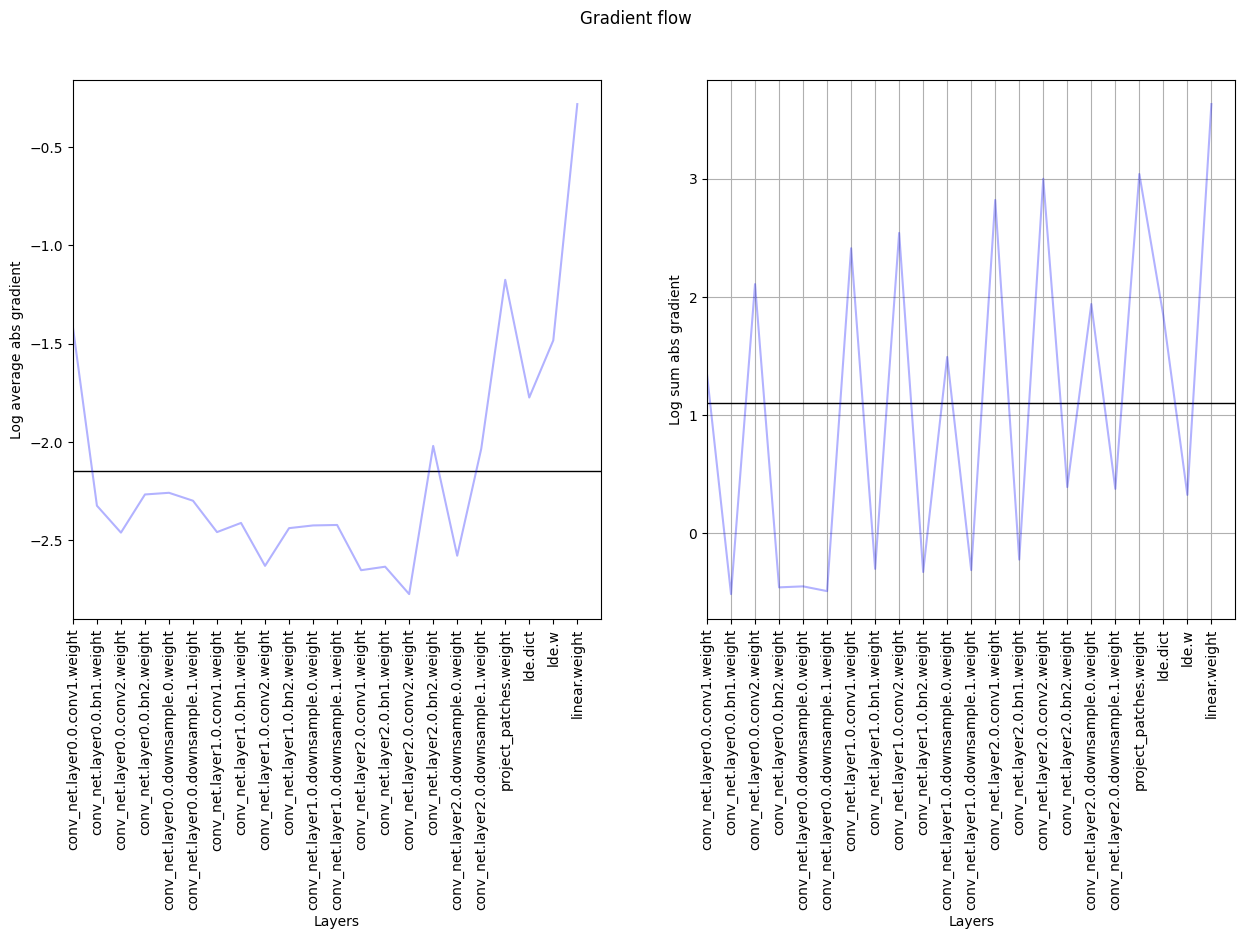

In [ ]:
targets = transform_labels_to_targets(labels)
train_loss = torch.mean((y-targets)**2)
train_loss.backward()
grad_dict = plot_grad_flow(neural_regression.named_parameters())

In [ ]:
y = None
q = None
input = None
labels = None
targets = None
train_loss = None


gc.collect()
torch.cuda.empty_cache()

## Trainer

In [ ]:
from pathlib import Path
def train_epoch(log_dir,regressor,
                train_loss_history = [],val_loss_history = [],
                t_cov_history = [],t_rev_history = [],
                report_iter = 1000,epoch_num=1):
  global optimizer 

  Path(log_dir).mkdir(parents=True, exist_ok=True)

  train_history = []
  train_t_cov_history = []
  train_t_rev_history = []
  regressor.train()


  for i,(input,labels) in enumerate(tqdm(train_loader)):

    input = input.to(device).unsqueeze(1)
    labels = labels.to(device)

    optimizer.zero_grad()

    y = regressor(input)
    loss = torch.mean((y-transform_labels_to_targets(labels))**2,dim=0)
    #loss = torch.mean(torch.abs(y-transform_labels_to_targets(torch.log10(out_labels[:,2:]))),dim=0)


    complete_loss = torch.mean(loss)

    complete_loss.backward()
    optimizer.step()

    train_history.append(complete_loss.item())
    train_t_cov_history.append(loss[0].item())
    train_t_rev_history.append(loss[1].item())

    if i%report_iter==(report_iter-1):
        print('Iter {} loss={:.4f} t_cov_loss ={:.4f} t_rev_loss = {:.4f}, t_cov_rmse = {:.4f}, t_rev_rmse = {:.4f}'.format(i+1,
                        np.mean(train_history[-report_iter:]),np.mean(train_t_cov_history[-report_iter:]),np.mean(train_t_rev_history[-report_iter:]),
                        np.sqrt(np.mean(train_t_cov_history[-report_iter:]))*label_std[0].item(),np.sqrt(np.mean(train_t_rev_history[-report_iter:]))*label_std[1].item()))


  input = None
  labels = None
  y = None
  loss = None
  complete_loss = None
  gc.collect()
  torch.cuda.empty_cache()

  val_history = []
  val_t_cov_history = []
  val_t_rev_history = []
  regressor.eval()

  for i,(input,labels) in enumerate(tqdm(val_loader)):

    input = input.to(device).unsqueeze(1)
    labels = labels.to(device)

    y = regressor(input)
    loss = torch.mean((y-transform_labels_to_targets(labels))**2,dim=0)
    complete_loss = torch.mean(loss)

    val_history.append(complete_loss.item())
    val_t_cov_history.append(loss[0].item())
    val_t_rev_history.append(loss[1].item())


  input = None
  labels = None
  y = None
  loss = None
  complete_loss = None
  gc.collect()
  torch.cuda.empty_cache()

  print('Epoch {}, Train loss {:.4f}, Val loss {:.4f} t_cov_loss {:.4f} t_rev_loss {:.4f} t_cov_rmse = {:.4f}, t_rev_rmse = {:.4f}'.format(epoch_num,
                      np.mean(train_history),np.mean(val_history),np.mean(val_t_cov_history),np.mean(val_t_rev_history),
                      np.sqrt(np.mean(val_t_cov_history))*label_std[0].item(),np.sqrt(np.mean(val_t_rev_history))*label_std[1].item()))
  
  train_loss_history.append(train_history)
  t_cov_history.append(train_t_cov_history)
  t_rev_history.append(train_t_rev_history)
  val_loss_history.append(np.mean(val_history))

  model_dict = {
                'regressor': neural_regression.state_dict(),
                'epoch': 1,
                'string': neural_regression.__str__(),
                'train_loss_history': train_loss_history,
                't_cov_history':t_cov_history,
                't_rev_history':t_rev_history,
                'val_loss_history':val_loss_history,
                'lr': optimizer.param_groups[0]['lr'],
                'log_tau_bounds':log_tau_bounds,
                'rho_bounds':rho_bounds,
                'label_mean':label_mean.detach().cpu().numpy(),
                'label_std':label_std.detach().cpu().numpy(),
                'optimizer_state_dict': optimizer.state_dict()}

  
  torch.save(model_dict, log_dir + '%d_epoch.pth'%epoch_num)

# 10 years observed, 10 years in saturation. Max log tau for 10 years, grid step=4 300k samples

## ResNet network

### ResNet first block 64 not strided. Then layers [1,1,1,0], strides [(1,2),(2,1),(2,2),(0,0)], LDE 64 clusters, 64 filters

In [ ]:
log_dir= Folder+'Neural_Networks/Neural_regression/10_years_Fourier_sampling_grid_step_4_300k_samples/ResNet_layers_1_1_1_0_strides_12_21_22_00_LDE_64_64_dropout_01/'
learning_rate = 1e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []
# Look what duration or logtau/logrho values initiate high losses. Find how to balance them out?

In [ ]:
# I shouldn't reinitialize the optimizer every time, cause it would forget the moments
optimizer = torch.optim.Adam(
                list(neural_regression.parameters()), lr=learning_rate
            )

In [ ]:
for epoch in range(0,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 11%|█         | 200/1875 [03:26<28:48,  1.03s/it]

Iter 200 loss=0.6925 t_cov_loss =0.4016 t_rev_loss = 0.9835, t_cov_rmse = 0.3131, t_rev_rmse = 2.7071


 21%|██▏       | 400/1875 [06:52<25:22,  1.03s/it]

Iter 400 loss=0.5533 t_cov_loss =0.1736 t_rev_loss = 0.9331, t_cov_rmse = 0.2059, t_rev_rmse = 2.6367


 32%|███▏      | 600/1875 [10:18<21:53,  1.03s/it]

Iter 600 loss=0.4460 t_cov_loss =0.1447 t_rev_loss = 0.7473, t_cov_rmse = 0.1880, t_rev_rmse = 2.3597


 43%|████▎     | 800/1875 [13:44<18:26,  1.03s/it]

Iter 800 loss=0.2606 t_cov_loss =0.1335 t_rev_loss = 0.3878, t_cov_rmse = 0.1805, t_rev_rmse = 1.6999


 53%|█████▎    | 1000/1875 [17:10<15:00,  1.03s/it]

Iter 1000 loss=0.1838 t_cov_loss =0.1149 t_rev_loss = 0.2527, t_cov_rmse = 0.1675, t_rev_rmse = 1.3723


 64%|██████▍   | 1200/1875 [20:36<11:34,  1.03s/it]

Iter 1200 loss=0.1638 t_cov_loss =0.1138 t_rev_loss = 0.2138, t_cov_rmse = 0.1667, t_rev_rmse = 1.2621


 75%|███████▍  | 1400/1875 [24:02<08:09,  1.03s/it]

Iter 1400 loss=0.1589 t_cov_loss =0.1106 t_rev_loss = 0.2072, t_cov_rmse = 0.1643, t_rev_rmse = 1.2425


 85%|████████▌ | 1600/1875 [27:28<04:43,  1.03s/it]

Iter 1600 loss=0.1499 t_cov_loss =0.1120 t_rev_loss = 0.1879, t_cov_rmse = 0.1653, t_rev_rmse = 1.1832


 96%|█████████▌| 1800/1875 [30:54<01:17,  1.03s/it]

Iter 1800 loss=0.1425 t_cov_loss =0.1067 t_rev_loss = 0.1783, t_cov_rmse = 0.1614, t_rev_rmse = 1.1526


100%|██████████| 234/234 [03:40<00:00,  1.06it/s]


Epoch 1, Train loss 0.2991, Val loss 0.1339 t_cov_loss 0.0996 t_rev_loss 0.1682 t_cov_rmse = 0.1559, t_rev_rmse = 1.1194


 11%|█         | 200/1875 [03:26<28:42,  1.03s/it]

Iter 200 loss=0.1413 t_cov_loss =0.1075 t_rev_loss = 0.1751, t_cov_rmse = 0.1620, t_rev_rmse = 1.1423


 21%|██▏       | 400/1875 [06:51<25:15,  1.03s/it]

Iter 400 loss=0.1339 t_cov_loss =0.1021 t_rev_loss = 0.1657, t_cov_rmse = 0.1579, t_rev_rmse = 1.1112


 28%|██▊       | 534/1875 [09:09<23:02,  1.03s/it]

In [ ]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%1)
neural_regression.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']
optimizer.load_state_dict(model_dict['optimizer_state_dict'])

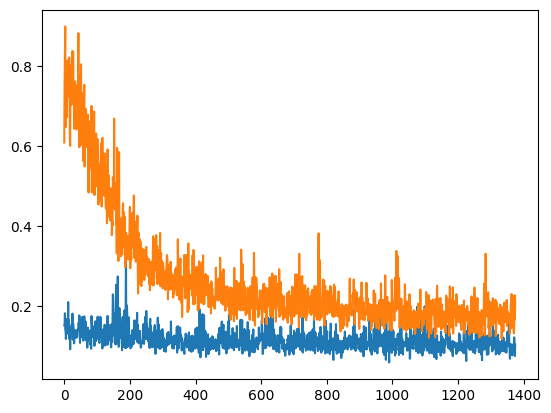

In [ ]:
plt.plot(np.array(t_cov_history).flatten()[500:])
plt.plot(np.array(t_rev_history).flatten()[500:])

In [ ]:
train_loader = get_dataloader(train_labels,random_seed=10)
val_loader = get_dataloader(val_labels,random_seed=11)
test_loader = get_dataloader(test_labels,random_seed=9)

In [ ]:
learning_rate = 5e-5
optimizer.param_groups[0]['lr'] = learning_rate

In [ ]:
for epoch in range(1,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 11%|█         | 200/1875 [03:38<30:03,  1.08s/it]

Iter 200 loss=0.1331 t_cov_loss =0.1002 t_rev_loss = 0.1661, t_cov_rmse = 0.1564, t_rev_rmse = 1.1124


 21%|██▏       | 400/1875 [07:13<26:26,  1.08s/it]

Iter 400 loss=0.1307 t_cov_loss =0.1010 t_rev_loss = 0.1605, t_cov_rmse = 0.1570, t_rev_rmse = 1.0936


 32%|███▏      | 600/1875 [10:49<22:56,  1.08s/it]

Iter 600 loss=0.1282 t_cov_loss =0.1007 t_rev_loss = 0.1558, t_cov_rmse = 0.1568, t_rev_rmse = 1.0773


 43%|████▎     | 800/1875 [14:24<19:18,  1.08s/it]

Iter 800 loss=0.1262 t_cov_loss =0.0981 t_rev_loss = 0.1544, t_cov_rmse = 0.1547, t_rev_rmse = 1.0727


 53%|█████▎    | 1000/1875 [17:59<15:39,  1.07s/it]

Iter 1000 loss=0.1268 t_cov_loss =0.0975 t_rev_loss = 0.1561, t_cov_rmse = 0.1542, t_rev_rmse = 1.0785


 64%|██████▍   | 1200/1875 [21:34<12:04,  1.07s/it]

Iter 1200 loss=0.1277 t_cov_loss =0.1004 t_rev_loss = 0.1550, t_cov_rmse = 0.1565, t_rev_rmse = 1.0748


 75%|███████▍  | 1400/1875 [25:09<08:30,  1.08s/it]

Iter 1400 loss=0.1239 t_cov_loss =0.0981 t_rev_loss = 0.1497, t_cov_rmse = 0.1547, t_rev_rmse = 1.0562


 85%|████████▌ | 1600/1875 [28:44<04:56,  1.08s/it]

Iter 1600 loss=0.1248 t_cov_loss =0.1004 t_rev_loss = 0.1492, t_cov_rmse = 0.1566, t_rev_rmse = 1.0543


 96%|█████████▌| 1800/1875 [32:19<01:20,  1.07s/it]

Iter 1800 loss=0.1224 t_cov_loss =0.0963 t_rev_loss = 0.1485, t_cov_rmse = 0.1533, t_rev_rmse = 1.0518


100%|██████████| 234/234 [03:51<00:00,  1.01it/s]


Epoch 2, Train loss 0.1268, Val loss 0.1146 t_cov_loss 0.0919 t_rev_loss 0.1372 t_cov_rmse = 0.1498, t_rev_rmse = 1.0109


 11%|█         | 200/1875 [03:35<30:03,  1.08s/it]

Iter 200 loss=0.1217 t_cov_loss =0.0980 t_rev_loss = 0.1455, t_cov_rmse = 0.1546, t_rev_rmse = 1.0411


 21%|██▏       | 400/1875 [07:10<26:24,  1.07s/it]

Iter 400 loss=0.1196 t_cov_loss =0.0964 t_rev_loss = 0.1429, t_cov_rmse = 0.1534, t_rev_rmse = 1.0320


 32%|███▏      | 600/1875 [10:45<22:50,  1.07s/it]

Iter 600 loss=0.1178 t_cov_loss =0.0956 t_rev_loss = 0.1400, t_cov_rmse = 0.1528, t_rev_rmse = 1.0214


 43%|████▎     | 800/1875 [14:20<19:15,  1.08s/it]

Iter 800 loss=0.1185 t_cov_loss =0.0935 t_rev_loss = 0.1434, t_cov_rmse = 0.1511, t_rev_rmse = 1.0338


 53%|█████▎    | 1000/1875 [17:55<15:39,  1.07s/it]

Iter 1000 loss=0.1147 t_cov_loss =0.0947 t_rev_loss = 0.1346, t_cov_rmse = 0.1521, t_rev_rmse = 1.0016


 64%|██████▍   | 1200/1875 [21:30<12:04,  1.07s/it]

Iter 1200 loss=0.1128 t_cov_loss =0.0912 t_rev_loss = 0.1344, t_cov_rmse = 0.1492, t_rev_rmse = 1.0008


 75%|███████▍  | 1400/1875 [25:05<08:28,  1.07s/it]

Iter 1400 loss=0.1180 t_cov_loss =0.0938 t_rev_loss = 0.1422, t_cov_rmse = 0.1513, t_rev_rmse = 1.0294


 85%|████████▌ | 1600/1875 [28:39<04:55,  1.07s/it]

Iter 1600 loss=0.1148 t_cov_loss =0.0936 t_rev_loss = 0.1359, t_cov_rmse = 0.1512, t_rev_rmse = 1.0064


 96%|█████████▌| 1800/1875 [32:14<01:20,  1.07s/it]

Iter 1800 loss=0.1148 t_cov_loss =0.0935 t_rev_loss = 0.1361, t_cov_rmse = 0.1511, t_rev_rmse = 1.0069


100%|██████████| 234/234 [03:49<00:00,  1.02it/s]


Epoch 3, Train loss 0.1168, Val loss 0.1151 t_cov_loss 0.0904 t_rev_loss 0.1398 t_cov_rmse = 0.1485, t_rev_rmse = 1.0206


  1%|          | 10/1875 [00:11<35:00,  1.13s/it]


KeyboardInterrupt: ignored

In [ ]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%3)
neural_regression.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']
optimizer.load_state_dict(model_dict['optimizer_state_dict'])

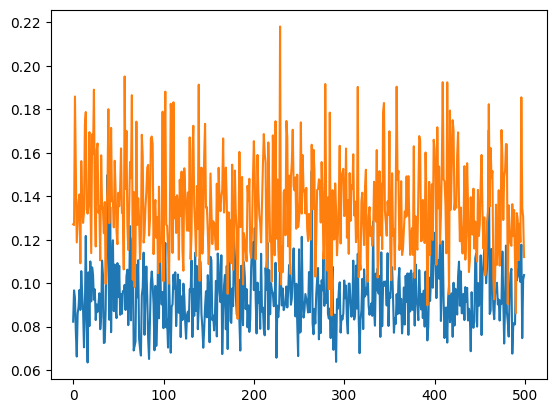

In [ ]:
plt.plot(np.array(t_cov_history).flatten()[-500:])
plt.plot(np.array(t_rev_history).flatten()[-500:])

In [ ]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%2)
neural_regression.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']
optimizer.load_state_dict(model_dict['optimizer_state_dict'])

In [ ]:
learning_rate = 1e-5
optimizer.param_groups[0]['lr'] = learning_rate

In [ ]:
for epoch in range(2,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 11%|█         | 200/1875 [03:35<30:11,  1.08s/it]

Iter 200 loss=0.1157 t_cov_loss =0.0935 t_rev_loss = 0.1378, t_cov_rmse = 0.1511, t_rev_rmse = 1.0135


 21%|██▏       | 400/1875 [07:10<26:26,  1.08s/it]

Iter 400 loss=0.1167 t_cov_loss =0.0939 t_rev_loss = 0.1396, t_cov_rmse = 0.1514, t_rev_rmse = 1.0199


 32%|███▏      | 600/1875 [10:44<22:46,  1.07s/it]

Iter 600 loss=0.1141 t_cov_loss =0.0925 t_rev_loss = 0.1358, t_cov_rmse = 0.1502, t_rev_rmse = 1.0058


 43%|████▎     | 800/1875 [14:19<19:12,  1.07s/it]

Iter 800 loss=0.1142 t_cov_loss =0.0924 t_rev_loss = 0.1360, t_cov_rmse = 0.1502, t_rev_rmse = 1.0067


 53%|█████▎    | 1000/1875 [17:53<15:39,  1.07s/it]

Iter 1000 loss=0.1151 t_cov_loss =0.0926 t_rev_loss = 0.1376, t_cov_rmse = 0.1503, t_rev_rmse = 1.0126


 64%|██████▍   | 1200/1875 [21:28<12:04,  1.07s/it]

Iter 1200 loss=0.1154 t_cov_loss =0.0941 t_rev_loss = 0.1367, t_cov_rmse = 0.1516, t_rev_rmse = 1.0092


 75%|███████▍  | 1400/1875 [25:02<08:29,  1.07s/it]

Iter 1400 loss=0.1139 t_cov_loss =0.0926 t_rev_loss = 0.1352, t_cov_rmse = 0.1504, t_rev_rmse = 1.0036


 85%|████████▌ | 1600/1875 [28:37<04:54,  1.07s/it]

Iter 1600 loss=0.1152 t_cov_loss =0.0936 t_rev_loss = 0.1369, t_cov_rmse = 0.1511, t_rev_rmse = 1.0099


 96%|█████████▌| 1800/1875 [32:11<01:20,  1.07s/it]

Iter 1800 loss=0.1138 t_cov_loss =0.0932 t_rev_loss = 0.1344, t_cov_rmse = 0.1508, t_rev_rmse = 1.0005


100%|██████████| 234/234 [03:49<00:00,  1.02it/s]


Epoch 3, Train loss 0.1149, Val loss 0.1125 t_cov_loss 0.0898 t_rev_loss 0.1351 t_cov_rmse = 0.1481, t_rev_rmse = 1.0032


 11%|█         | 200/1875 [03:34<30:01,  1.08s/it]

Iter 200 loss=0.1136 t_cov_loss =0.0937 t_rev_loss = 0.1335, t_cov_rmse = 0.1512, t_rev_rmse = 0.9975


 21%|██▏       | 400/1875 [07:10<26:28,  1.08s/it]

Iter 400 loss=0.1138 t_cov_loss =0.0928 t_rev_loss = 0.1349, t_cov_rmse = 0.1505, t_rev_rmse = 1.0026


 32%|███▏      | 600/1875 [10:45<22:55,  1.08s/it]

Iter 600 loss=0.1148 t_cov_loss =0.0941 t_rev_loss = 0.1356, t_cov_rmse = 0.1515, t_rev_rmse = 1.0050


 43%|████▎     | 800/1875 [14:21<19:19,  1.08s/it]

Iter 800 loss=0.1132 t_cov_loss =0.0932 t_rev_loss = 0.1331, t_cov_rmse = 0.1508, t_rev_rmse = 0.9959


 53%|█████▎    | 1000/1875 [17:56<15:41,  1.08s/it]

Iter 1000 loss=0.1129 t_cov_loss =0.0917 t_rev_loss = 0.1341, t_cov_rmse = 0.1496, t_rev_rmse = 0.9995


 64%|██████▍   | 1200/1875 [21:31<12:08,  1.08s/it]

Iter 1200 loss=0.1111 t_cov_loss =0.0904 t_rev_loss = 0.1319, t_cov_rmse = 0.1485, t_rev_rmse = 0.9912


 75%|███████▍  | 1400/1875 [25:07<08:30,  1.08s/it]

Iter 1400 loss=0.1108 t_cov_loss =0.0911 t_rev_loss = 0.1304, t_cov_rmse = 0.1491, t_rev_rmse = 0.9857


 85%|████████▌ | 1600/1875 [28:42<04:55,  1.08s/it]

Iter 1600 loss=0.1125 t_cov_loss =0.0913 t_rev_loss = 0.1336, t_cov_rmse = 0.1493, t_rev_rmse = 0.9978


 96%|█████████▌| 1800/1875 [32:17<01:20,  1.08s/it]

Iter 1800 loss=0.1113 t_cov_loss =0.0917 t_rev_loss = 0.1308, t_cov_rmse = 0.1496, t_rev_rmse = 0.9872


100%|██████████| 234/234 [03:50<00:00,  1.02it/s]


Epoch 4, Train loss 0.1126, Val loss 0.1107 t_cov_loss 0.0927 t_rev_loss 0.1288 t_cov_rmse = 0.1504, t_rev_rmse = 0.9795


  9%|▉         | 171/1875 [03:04<30:38,  1.08s/it]


KeyboardInterrupt: ignored

#### checks

In [ ]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%4)
neural_regression.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']
optimizer.load_state_dict(model_dict['optimizer_state_dict'])

In [ ]:
Performance_array = np.empty(shape=(0,4))
result = np.zeros((batch_size,4))


for i,(input,labels) in enumerate(tqdm(test_loader)):

  input = input.to(device).unsqueeze(1)
  labels = labels.to(device)

  y = neural_regression(input)
  prediction = transform_targets_to_labels(y)


  result[:,0:2] = labels.cpu().numpy()
  result[:,2:4] = prediction.cpu().detach().numpy()

  Performance_array = np.append(Performance_array,result,axis=0)

100%|██████████| 234/234 [03:40<00:00,  1.06it/s]


In [ ]:
import pandas as pd
df = pd.DataFrame(Performance_array,columns=['true logtau','true rho','pred logtau','pred rho'])

df.to_csv(log_dir + 'Performance.csv')

In [ ]:
df['err logtau'] = df['true logtau'] - df['pred logtau']
df['err rho'] = df['true rho'] - df['pred rho']

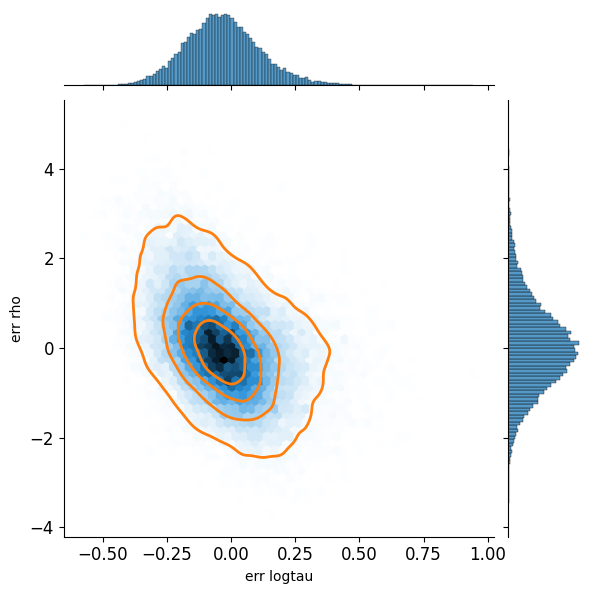

In [ ]:
g = sns.jointplot(data=df,x='err logtau', y='err rho', kind="hex",color='C0')
#g.ax_joint.set_xlabel(r'$log(\tau_{pred}) - log(\tau_{true})$',fontsize=FS)
#g.ax_joint.set_ylabel(r'$log(\rho_{pred}) - log(\rho_{true})$',fontsize=FS)
g.ax_joint.tick_params(axis='both', which='major', labelsize=12)


xlim = g.ax_joint.get_xlim()
ylim = g.ax_joint.get_ylim()

#sns.kdeplot(x=errors[0,bounds_mask], y=errors[1,bounds_mask], levels=np.linspace(0.2,0.8,10) ,color="C1", linewidths=2)
sns.kdeplot(data=df,x='err logtau', y='err rho', levels=5 ,color="C1", linewidths=2)

In [ ]:
df[['err logtau','err rho']].apply([lambda x: np.median(np.abs(x)),lambda x: np.mean(np.abs(x)),lambda x: np.mean(x**2)])

err logtau                       err rho                    
        <lambda>  <lambda>  <lambda>  <lambda>  <lambda>  <lambda>
0       0.183975  0.183975  0.033847  1.715188  1.715188  2.941870
1       0.140526  0.140526  0.019748  0.930139  0.930139  0.865158
2       0.042135  0.042135  0.001775  0.247404  0.247404  0.061209
3       0.008906  0.008906  0.000079  0.178910  0.178910  0.032009
4       0.114731  0.114731  0.013163  1.917851  1.917851  3.678154
...          ...       ...       ...       ...       ...       ...
29947   0.124605  0.124605  0.015526  1.284185  1.284185  1.649132
29948   0.185102  0.185102  0.034263  2.183237  2.183237  4.766524
29949   0.016787  0.016787  0.000282  0.556516  0.556516  0.309710
29950   0.430426  0.430426  0.185266  1.643221  1.643221  2.700175
29951   0.122745  0.122745  0.015066  0.266500  0.266500  0.071023

[29952 rows x 6 columns]

In [ ]:
MAD = np.median(np.abs(df[['err logtau','err rho']]),axis=0)
MAE = np.mean(np.abs(df[['err logtau','err rho']]),axis=0)
RMSE = np.sqrt(np.mean((df[['err logtau','err rho']])**2,axis=0))

In [ ]:
MAD

array([0.09900123, 0.60849428])

In [ ]:
MAE

err logtau    0.119269
err rho       0.761639
dtype: float64

In [ ]:
RMSE

err logtau    0.151213
err rho       0.983481
dtype: float64

In [ ]:
df_round = df[['true logtau','true rho','err logtau','err rho']].copy()
df_round.iloc[:,0:2] = (df_round.iloc[:,0:2]*5).round()/5
df_round['logtau abs error'] = np.abs(df_round['err logtau'])
df_round['rho abs error'] = np.abs(df_round['err rho'])

In [ ]:
logtau_errs

logtau abs error                                          \
true rho                0.6       0.8       1.0       1.2       1.4    
true logtau                                                            
1.0                 0.103880  0.061830  0.116403  0.074177  0.081906   
1.2                 0.055323  0.062517  0.055755  0.071945  0.057646   
1.4                 0.070372  0.074719  0.064804  0.071514  0.083474   
1.6                 0.094334  0.097204  0.062714  0.074119  0.075525   
1.8                 0.099668  0.100949  0.088694  0.098724  0.080514   
2.0                 0.096012  0.101746  0.107219  0.096168  0.107098   
2.2                 0.090587  0.074468  0.094606  0.120306  0.100065   
2.4                 0.116309  0.106298  0.096050  0.094640  0.096897   
2.6                 0.114681  0.091610  0.111103  0.114757  0.124636   
2.8                 0.152133  0.124257  0.117445  0.093164  0.222011   

                                                               ...            \
true rho         1.6       1.8       2.0       2.2       2.4   ...      8.2    
true logtau                                                    ...             
1.0          0.092374  0.089321  0.092568  0.104603  0.095755  ...  0.203325   
1.2          0.074736  0.077183  0.070529  0.065251  0.060590  ...  0.091006   
1.4          0.075098  0.064635  0.064118  0.070409  0.056609  ...  0.089139   
1.6          0.077915  0.072975  0.081090  0.067627  0.060312  ...  0.118527   
1.8          0.088121  0.093411  0.102896  0.101133  0.089895  ...  0.139160   
2.0          0.094947  0.092127  0.117833  0.106529  0.093715  ...  0.156896   
2.2          0.118577  0.118279  0.130810  0.095124  0.111662  ...  0.132559   
2.4          0.132777  0.104618  0.108443  0.113338  0.101368  ...  0.106028   
2.6          0.116679  0.107766  0.105046  0.118026  0.087236  ...  0.073349   
2.8          0.118455  0.154496  0.157366  0.113555  0.104759  ...  0.207988   

                                                                         \
true rho         8.4       8.6       8.8       9.0       9.2       9.4    
true logtau                                                               
1.0          0.128381  0.073483  0.168387  0.104213  0.174433  0.194695   
1.2          0.103821  0.103321  0.116485  0.098777  0.117713  0.136130   
1.4          0.105918  0.086830  0.111957  0.135242  0.088241  0.113969   
1.6          0.102781  0.119370  0.091463  0.131744  0.142713  0.088599   
1.8          0.139466  0.111356  0.109989  0.131965  0.133739  0.117146   
2.0          0.111176  0.150346  0.139657  0.161631  0.140400  0.142785   
2.2          0.125285  0.139796  0.099901  0.156755  0.151388  0.141639   
2.4          0.123395  0.085582  0.117228  0.131550  0.091630  0.088990   
2.6          0.093375  0.091108  0.096150  0.081575  0.083282  0.076469   
2.8          0.079982  0.168989  0.154323  0.135694  0.127531  0.116894   

                                           
true rho         9.6       9.8       10.0  
true logtau                                
1.0          0.150287  0.158384  0.171189  
1.2          0.103261  0.142227  0.123044  
1.4          0.106543  0.150349  0.126950  
1.6          0.159518  0.119528  0.172449  
1.8          0.146244  0.141119  0.139757  
2.0          0.170675  0.187568  0.145959  
2.2          0.135147  0.135502  0.159675  
2.4          0.102743  0.101864  0.073025  
2.6          0.071960  0.089726  0.067462  
2.8          0.116929  0.083872  0.165477  

[10 rows x 48 columns]

Text(50.722222222222214, 0.5, 'Ground truth $\\rho$')

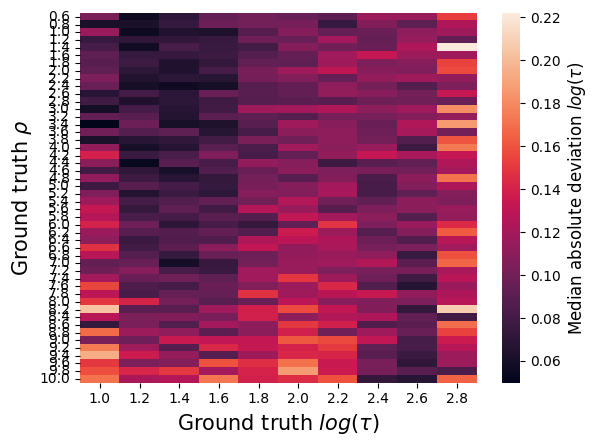

In [ ]:
distr_errs = df_round[['true logtau','true rho','logtau abs error']].groupby(['true logtau','true rho']).agg('median')
logtau_errs = distr_errs.unstack(level=-1)
g = sns.heatmap(logtau_errs.T,yticklabels=(np.arange(0.6*5,10.2*5,.2*5)/5))

g.collections[0].colorbar.set_label('Median absolute deviation '+r'$log(\tau)$',fontsize=12)
g.set_xlabel('Ground truth '+r'$log(\tau)$',fontsize=15)
g.set_ylabel('Ground truth '+r'$\rho$',fontsize=15)

Text(50.722222222222214, 0.5, 'Ground truth $\\rho$')

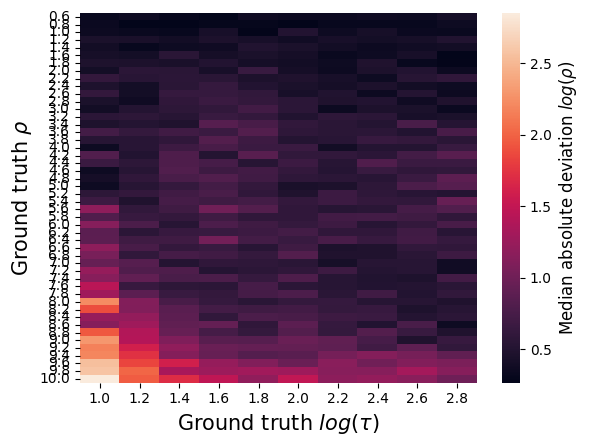

In [ ]:
distr_errs = df_round[['true logtau','true rho','rho abs error']].groupby(['true logtau','true rho']).agg('median')
logtau_errs = distr_errs.unstack(level=-1)
g = sns.heatmap(logtau_errs.T,yticklabels=(np.arange(0.6*5,10.2*5,.2*5)/5))

g.collections[0].colorbar.set_label('Median absolute deviation '+r'$log(\rho)$',fontsize=12)
g.set_xlabel('Ground truth '+r'$log(\tau)$',fontsize=15)
g.set_ylabel('Ground truth '+r'$\rho$',fontsize=15)

In [ ]:
input,labels = next(iter(test_loader))
input = input.to(device).unsqueeze(1)
labels = labels.to(device)

In [ ]:
predictions = transform_targets_to_labels(neural_regression(input))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


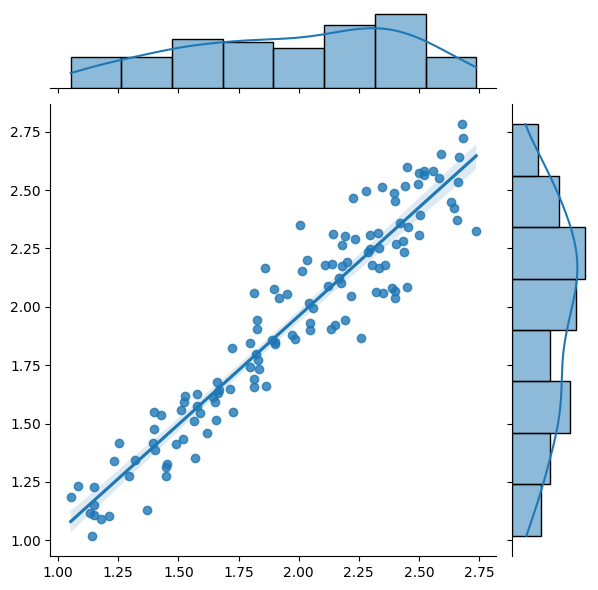

In [ ]:
sns.jointplot(labels[:,0].cpu(),predictions[:,0].cpu().detach(),kind='reg')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


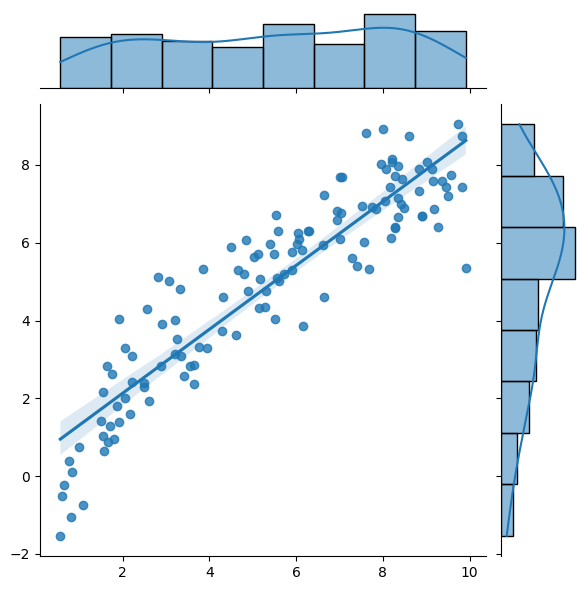

In [ ]:
sns.jointplot(labels[:,1].cpu(),predictions[:,1].cpu().detach(),kind='reg')

### ResNet first block 64 not strided. Then layers [1,1,1,0], strides [(1,2),(2,1),(2,1),(0,0)], LDE 64 clusters, 64 filters

In [ ]:
log_dir= Folder+'Neural_Networks/Neural_regression/10_years_Fourier_sampling_grid_step_4_300k_samples/ResNet_layers_1_1_1_0_strides_12_21_21_00_LDE_64_64_dropout_01/'
learning_rate = 1e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []
# Look what duration or logtau/logrho values initiate high losses. Find how to balance them out?

In [ ]:
# I shouldn't reinitialize the optimizer every time, cause it would forget the moments
optimizer = torch.optim.Adam(
                list(neural_regression.parameters()), lr=learning_rate
            )

In [ ]:
for epoch in range(0,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 11%|█         | 200/1875 [03:44<31:04,  1.11s/it]

Iter 200 loss=0.6545 t_cov_loss =0.3281 t_rev_loss = 0.9809, t_cov_rmse = 0.2830, t_rev_rmse = 2.7035


 21%|██▏       | 400/1875 [07:27<27:20,  1.11s/it]

Iter 400 loss=0.5041 t_cov_loss =0.1641 t_rev_loss = 0.8440, t_cov_rmse = 0.2002, t_rev_rmse = 2.5078


 32%|███▏      | 600/1875 [11:10<23:35,  1.11s/it]

Iter 600 loss=0.3559 t_cov_loss =0.1347 t_rev_loss = 0.5771, t_cov_rmse = 0.1813, t_rev_rmse = 2.0736


 43%|████▎     | 800/1875 [14:52<19:52,  1.11s/it]

Iter 800 loss=0.2694 t_cov_loss =0.1265 t_rev_loss = 0.4124, t_cov_rmse = 0.1757, t_rev_rmse = 1.7529


 53%|█████▎    | 1000/1875 [18:35<16:11,  1.11s/it]

Iter 1000 loss=0.2285 t_cov_loss =0.1244 t_rev_loss = 0.3326, t_cov_rmse = 0.1743, t_rev_rmse = 1.5741


 64%|██████▍   | 1200/1875 [22:17<12:33,  1.12s/it]

Iter 1200 loss=0.2031 t_cov_loss =0.1096 t_rev_loss = 0.2965, t_cov_rmse = 0.1636, t_rev_rmse = 1.4864


 75%|███████▍  | 1400/1875 [26:00<08:47,  1.11s/it]

Iter 1400 loss=0.1884 t_cov_loss =0.1122 t_rev_loss = 0.2647, t_cov_rmse = 0.1655, t_rev_rmse = 1.4044


 85%|████████▌ | 1600/1875 [29:42<05:05,  1.11s/it]

Iter 1600 loss=0.1748 t_cov_loss =0.1030 t_rev_loss = 0.2467, t_cov_rmse = 0.1586, t_rev_rmse = 1.3558


 96%|█████████▌| 1800/1875 [33:24<01:23,  1.11s/it]

Iter 1800 loss=0.1658 t_cov_loss =0.1053 t_rev_loss = 0.2264, t_cov_rmse = 0.1603, t_rev_rmse = 1.2987


100%|██████████| 234/234 [03:54<00:00,  1.00s/it]


Epoch 1, Train loss 0.2990, Val loss 0.1610 t_cov_loss 0.0948 t_rev_loss 0.2272 t_cov_rmse = 0.1521, t_rev_rmse = 1.3010


 11%|█         | 200/1875 [03:42<31:05,  1.11s/it]

Iter 200 loss=0.1578 t_cov_loss =0.1016 t_rev_loss = 0.2141, t_cov_rmse = 0.1575, t_rev_rmse = 1.2631


 21%|██▏       | 400/1875 [07:25<27:35,  1.12s/it]

Iter 400 loss=0.1504 t_cov_loss =0.0988 t_rev_loss = 0.2021, t_cov_rmse = 0.1553, t_rev_rmse = 1.2272


 29%|██▉       | 542/1875 [10:04<24:45,  1.11s/it]


KeyboardInterrupt: ignored

In [ ]:
11%|█         | 200/1875 [03:26<28:48,  1.03s/it]Iter 200 loss=0.6925 t_cov_loss =0.4016 t_rev_loss = 0.9835, t_cov_rmse = 0.3131, t_rev_rmse = 2.7071
 21%|██▏       | 400/1875 [06:52<25:22,  1.03s/it]Iter 400 loss=0.5533 t_cov_loss =0.1736 t_rev_loss = 0.9331, t_cov_rmse = 0.2059, t_rev_rmse = 2.6367
 32%|███▏      | 600/1875 [10:18<21:53,  1.03s/it]Iter 600 loss=0.4460 t_cov_loss =0.1447 t_rev_loss = 0.7473, t_cov_rmse = 0.1880, t_rev_rmse = 2.3597
 43%|████▎     | 800/1875 [13:44<18:26,  1.03s/it]Iter 800 loss=0.2606 t_cov_loss =0.1335 t_rev_loss = 0.3878, t_cov_rmse = 0.1805, t_rev_rmse = 1.6999
 53%|█████▎    | 1000/1875 [17:10<15:00,  1.03s/it]Iter 1000 loss=0.1838 t_cov_loss =0.1149 t_rev_loss = 0.2527, t_cov_rmse = 0.1675, t_rev_rmse = 1.3723
 64%|██████▍   | 1200/1875 [20:36<11:34,  1.03s/it]Iter 1200 loss=0.1638 t_cov_loss =0.1138 t_rev_loss = 0.2138, t_cov_rmse = 0.1667, t_rev_rmse = 1.2621
 75%|███████▍  | 1400/1875 [24:02<08:09,  1.03s/it]Iter 1400 loss=0.1589 t_cov_loss =0.1106 t_rev_loss = 0.2072, t_cov_rmse = 0.1643, t_rev_rmse = 1.2425
 85%|████████▌ | 1600/1875 [27:28<04:43,  1.03s/it]Iter 1600 loss=0.1499 t_cov_loss =0.1120 t_rev_loss = 0.1879, t_cov_rmse = 0.1653, t_rev_rmse = 1.1832
 96%|█████████▌| 1800/1875 [30:54<01:17,  1.03s/it]Iter 1800 loss=0.1425 t_cov_loss =0.1067 t_rev_loss = 0.1783, t_cov_rmse = 0.1614, t_rev_rmse = 1.1526
100%|██████████| 1875/1875 [32:11<00:00,  1.03s/it]
100%|██████████| 234/234 [03:40<00:00,  1.06it/s]

### ResNet first block 64 not strided. Then layers [1,1,0], strides [(2,2),(2,2),(0,0)], LDE 64 clusters, 64 filters

In [ ]:
log_dir= Folder+'Neural_Networks/Neural_regression/10_years_Fourier_sampling_grid_step_4_300k_samples/ResNet_layers_1_1_1_0_strides_11_22_22_00_LDE_64_64_dropout_01/'
learning_rate = 1e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []
# Look what duration or logtau/logrho values initiate high losses. Find how to balance them out?

In [ ]:
# I shouldn't reinitialize the optimizer every time, cause it would forget the moments
optimizer = torch.optim.Adam(
                list(neural_regression.parameters()), lr=learning_rate
            )

In [ ]:
for epoch in range(0,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 11%|█         | 200/1875 [03:33<29:29,  1.06s/it]

Iter 200 loss=0.6687 t_cov_loss =0.3399 t_rev_loss = 0.9974, t_cov_rmse = 0.2881, t_rev_rmse = 2.7261


 21%|██▏       | 400/1875 [07:04<26:01,  1.06s/it]

Iter 400 loss=0.5488 t_cov_loss =0.1717 t_rev_loss = 0.9259, t_cov_rmse = 0.2047, t_rev_rmse = 2.6265


 32%|███▏      | 600/1875 [10:35<22:27,  1.06s/it]

Iter 600 loss=0.4844 t_cov_loss =0.1579 t_rev_loss = 0.8109, t_cov_rmse = 0.1963, t_rev_rmse = 2.4580


 43%|████▎     | 800/1875 [14:07<18:54,  1.06s/it]

Iter 800 loss=0.3439 t_cov_loss =0.1378 t_rev_loss = 0.5500, t_cov_rmse = 0.1834, t_rev_rmse = 2.0244


 53%|█████▎    | 1000/1875 [17:38<15:25,  1.06s/it]

Iter 1000 loss=0.2214 t_cov_loss =0.1284 t_rev_loss = 0.3144, t_cov_rmse = 0.1770, t_rev_rmse = 1.5306


 60%|██████    | 1131/1875 [19:58<13:08,  1.06s/it]


KeyboardInterrupt: ignored

### ResNet layers [1,1,0], strides [2,2,2], LDE 64 clusters, 64 filters

In [ ]:
log_dir= Folder+'Neural_Networks/Neural_regression/10_years_Fourier_sampling_grid_step_4_300k_samples/ResNet_1_1_0_2_2_2_LDE_64_64_dropout_01/'
learning_rate = 1e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []
# Look what duration or logtau/logrho values initiate high losses. Find how to balance them out?

In [ ]:
# I shouldn't reinitialize the optimizer every time, cause it would forget the moments
optimizer = torch.optim.Adam(
                list(neural_regression.parameters()), lr=learning_rate
            )

In [ ]:
# Here filters are 1->32->64. Change to 1->64->64
for epoch in range(0,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 11%|█         | 200/1875 [03:37<30:29,  1.09s/it]

Iter 200 loss=0.6115 t_cov_loss =0.2483 t_rev_loss = 0.9747, t_cov_rmse = 0.2462, t_rev_rmse = 2.6950


 21%|██▏       | 400/1875 [07:14<26:38,  1.08s/it]

Iter 400 loss=0.5075 t_cov_loss =0.1389 t_rev_loss = 0.8761, t_cov_rmse = 0.1842, t_rev_rmse = 2.5550


 32%|███▏      | 600/1875 [10:51<22:55,  1.08s/it]

Iter 600 loss=0.3334 t_cov_loss =0.1209 t_rev_loss = 0.5458, t_cov_rmse = 0.1718, t_rev_rmse = 2.0167


 43%|████▎     | 800/1875 [14:28<19:24,  1.08s/it]

Iter 800 loss=0.2410 t_cov_loss =0.1190 t_rev_loss = 0.3631, t_cov_rmse = 0.1704, t_rev_rmse = 1.6449


 53%|█████▎    | 1000/1875 [18:04<15:48,  1.08s/it]

Iter 1000 loss=0.1979 t_cov_loss =0.1121 t_rev_loss = 0.2837, t_cov_rmse = 0.1654, t_rev_rmse = 1.4540


 64%|██████▍   | 1200/1875 [21:41<12:10,  1.08s/it]

Iter 1200 loss=0.1843 t_cov_loss =0.1113 t_rev_loss = 0.2573, t_cov_rmse = 0.1649, t_rev_rmse = 1.3845


 75%|███████▍  | 1400/1875 [25:18<08:33,  1.08s/it]

Iter 1400 loss=0.1702 t_cov_loss =0.1046 t_rev_loss = 0.2358, t_cov_rmse = 0.1598, t_rev_rmse = 1.3255


 85%|████████▌ | 1600/1875 [28:55<04:57,  1.08s/it]

Iter 1600 loss=0.1634 t_cov_loss =0.1073 t_rev_loss = 0.2194, t_cov_rmse = 0.1619, t_rev_rmse = 1.2787


 96%|█████████▌| 1800/1875 [32:32<01:21,  1.09s/it]

Iter 1800 loss=0.1570 t_cov_loss =0.1043 t_rev_loss = 0.2097, t_cov_rmse = 0.1596, t_rev_rmse = 1.2500


100%|██████████| 234/234 [04:03<00:00,  1.04s/it]


Epoch 1, Train loss 0.2800, Val loss 0.1563 t_cov_loss 0.0946 t_rev_loss 0.2179 t_cov_rmse = 0.1520, t_rev_rmse = 1.2743


  1%|          | 17/1875 [00:19<34:52,  1.13s/it]


KeyboardInterrupt: ignored

In [ ]:
# first layers are 7x7 conv and max pool
for epoch in range(0,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 11%|█         | 200/1875 [03:40<31:24,  1.13s/it]

Iter 200 loss=0.7460 t_cov_loss =0.3406 t_rev_loss = 1.1514, t_cov_rmse = 0.2883, t_rev_rmse = 2.9290


 21%|██▏       | 400/1875 [07:17<26:35,  1.08s/it]

Iter 400 loss=0.4619 t_cov_loss =0.1565 t_rev_loss = 0.7674, t_cov_rmse = 0.1954, t_rev_rmse = 2.3912


 32%|███▏      | 600/1875 [10:54<23:02,  1.08s/it]

Iter 600 loss=0.2624 t_cov_loss =0.1338 t_rev_loss = 0.3910, t_cov_rmse = 0.1807, t_rev_rmse = 1.7068


 43%|████▎     | 800/1875 [14:31<19:20,  1.08s/it]

Iter 800 loss=0.2252 t_cov_loss =0.1260 t_rev_loss = 0.3244, t_cov_rmse = 0.1754, t_rev_rmse = 1.5547


 53%|█████▎    | 1000/1875 [18:07<15:43,  1.08s/it]

Iter 1000 loss=0.1868 t_cov_loss =0.1150 t_rev_loss = 0.2587, t_cov_rmse = 0.1675, t_rev_rmse = 1.3884


 64%|██████▍   | 1200/1875 [21:43<12:08,  1.08s/it]

Iter 1200 loss=0.1749 t_cov_loss =0.1091 t_rev_loss = 0.2408, t_cov_rmse = 0.1632, t_rev_rmse = 1.3394


 75%|███████▍  | 1400/1875 [25:20<08:33,  1.08s/it]

Iter 1400 loss=0.1694 t_cov_loss =0.1117 t_rev_loss = 0.2271, t_cov_rmse = 0.1651, t_rev_rmse = 1.3009


 85%|████████▌ | 1600/1875 [28:56<04:56,  1.08s/it]

Iter 1600 loss=0.1578 t_cov_loss =0.1057 t_rev_loss = 0.2098, t_cov_rmse = 0.1607, t_rev_rmse = 1.2503


 96%|█████████▌| 1800/1875 [32:32<01:21,  1.08s/it]

Iter 1800 loss=0.1586 t_cov_loss =0.1076 t_rev_loss = 0.2096, t_cov_rmse = 0.1621, t_rev_rmse = 1.2498


100%|██████████| 234/234 [04:03<00:00,  1.04s/it]


Epoch 1, Train loss 0.2774, Val loss 0.1982 t_cov_loss 0.1093 t_rev_loss 0.2872 t_cov_rmse = 0.1633, t_rev_rmse = 1.4629


 11%|█         | 200/1875 [03:37<30:21,  1.09s/it]

Iter 200 loss=0.1626 t_cov_loss =0.1091 t_rev_loss = 0.2161, t_cov_rmse = 0.1632, t_rev_rmse = 1.2690


 21%|██▏       | 400/1875 [07:14<26:30,  1.08s/it]

Iter 400 loss=0.1506 t_cov_loss =0.1038 t_rev_loss = 0.1973, t_cov_rmse = 0.1592, t_rev_rmse = 1.2125


 25%|██▌       | 474/1875 [08:34<25:20,  1.09s/it]


KeyboardInterrupt: ignored

In [ ]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%1)
neural_regression.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']
optimizer.load_state_dict(model_dict['optimizer_state_dict'])

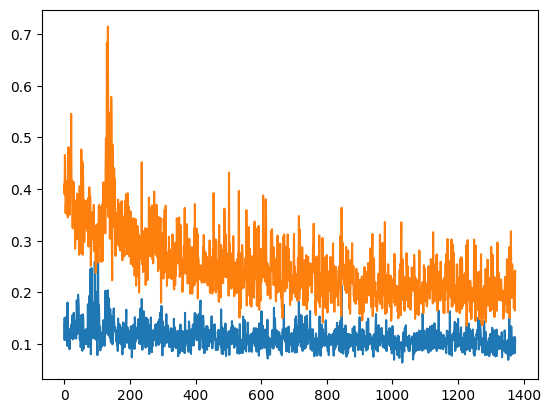

In [ ]:
# the performance in rho might be so bad because the net goes conv(())

plt.plot(np.array(t_cov_history).flatten()[500:])
plt.plot(np.array(t_rev_history).flatten()[500:])

In [ ]:
learning_rate = 5e-5
optimizer.param_groups[0]['lr'] = learning_rate

In [ ]:
for epoch in range(1,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 11%|█         | 200/1875 [03:39<30:20,  1.09s/it]

Iter 200 loss=0.1450 t_cov_loss =0.1000 t_rev_loss = 0.1900, t_cov_rmse = 0.1563, t_rev_rmse = 1.1899


 15%|█▌        | 286/1875 [05:15<29:13,  1.10s/it]


KeyboardInterrupt: ignored

In [ ]:
for epoch in range(0,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 11%|█         | 200/1875 [03:23<28:09,  1.01s/it]

Iter 200 loss=0.6012 t_cov_loss =0.2891 t_rev_loss = 0.9133, t_cov_rmse = 0.2656, t_rev_rmse = 2.6087


 21%|██▏       | 400/1875 [06:44<24:47,  1.01s/it]

Iter 400 loss=0.3203 t_cov_loss =0.1330 t_rev_loss = 0.5076, t_cov_rmse = 0.1802, t_rev_rmse = 1.9448


 32%|███▏      | 600/1875 [10:05<21:18,  1.00s/it]

Iter 600 loss=0.2232 t_cov_loss =0.1255 t_rev_loss = 0.3209, t_cov_rmse = 0.1750, t_rev_rmse = 1.5463


 43%|████▎     | 800/1875 [13:27<18:08,  1.01s/it]

Iter 800 loss=0.1964 t_cov_loss =0.1198 t_rev_loss = 0.2729, t_cov_rmse = 0.1710, t_rev_rmse = 1.4261


 47%|████▋     | 885/1875 [14:52<16:36,  1.01s/it]

# 10 years observed, 10 years in saturation. Max log tau for 10 years, grid step=4

## ResNet network

### ResNet layers [1,1,0], strides [2,2,2], LDE 64 clusters, 64 filters

In [ ]:
log_dir= Folder+'Neural_Networks/Neural_regression/10_years_Fourier_sampling_grid_step_4/ResNet_1_1_0_2_2_2_LDE_64_64_dropout_01/'
learning_rate = 1e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []
# Look what duration or logtau/logrho values initiate high losses. Find how to balance them out?

In [ ]:
# I shouldn't reinitialize the optimizer every time, cause it would forget the moments
optimizer = torch.optim.Adam(
                list(neural_regression.parameters()), lr=learning_rate
            )

In [ ]:
for epoch in range(0,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [03:24<07:07,  1.01s/it]

Iter 200 loss=0.6142 t_cov_loss =0.2708 t_rev_loss = 0.9575, t_cov_rmse = 0.2566, t_rev_rmse = 2.6813


 64%|██████▍   | 400/625 [06:45<03:47,  1.01s/it]

Iter 400 loss=0.3600 t_cov_loss =0.1412 t_rev_loss = 0.5787, t_cov_rmse = 0.1853, t_rev_rmse = 2.0845


 96%|█████████▌| 600/625 [10:07<00:25,  1.01s/it]

Iter 600 loss=0.2315 t_cov_loss =0.1276 t_rev_loss = 0.3353, t_cov_rmse = 0.1761, t_rev_rmse = 1.5867


100%|██████████| 78/78 [01:16<00:00,  1.02it/s]


Epoch 1, Train loss 0.3940, Val loss 0.1912 t_cov_loss 0.1123 t_rev_loss 0.2702 t_cov_rmse = 0.1652, t_rev_rmse = 1.4242


 32%|███▏      | 200/625 [03:21<07:06,  1.00s/it]

Iter 200 loss=0.2050 t_cov_loss =0.1223 t_rev_loss = 0.2876, t_cov_rmse = 0.1724, t_rev_rmse = 1.4696


 64%|██████▍   | 400/625 [06:42<03:46,  1.01s/it]

Iter 400 loss=0.1899 t_cov_loss =0.1142 t_rev_loss = 0.2657, t_cov_rmse = 0.1666, t_rev_rmse = 1.4123


 96%|█████████▌| 600/625 [10:03<00:25,  1.01s/it]

Iter 600 loss=0.1798 t_cov_loss =0.1140 t_rev_loss = 0.2456, t_cov_rmse = 0.1664, t_rev_rmse = 1.3579


100%|██████████| 78/78 [01:14<00:00,  1.04it/s]


Epoch 2, Train loss 0.1904, Val loss 0.1572 t_cov_loss 0.1013 t_rev_loss 0.2131 t_cov_rmse = 0.1569, t_rev_rmse = 1.2650


 32%|███▏      | 200/625 [03:20<07:06,  1.00s/it]

Iter 200 loss=0.1764 t_cov_loss =0.1173 t_rev_loss = 0.2355, t_cov_rmse = 0.1689, t_rev_rmse = 1.3297


 64%|██████▍   | 400/625 [06:41<03:45,  1.00s/it]

Iter 400 loss=0.1680 t_cov_loss =0.1067 t_rev_loss = 0.2294, t_cov_rmse = 0.1611, t_rev_rmse = 1.3123


 96%|█████████▌| 600/625 [10:02<00:25,  1.00s/it]

Iter 600 loss=0.1616 t_cov_loss =0.1070 t_rev_loss = 0.2162, t_cov_rmse = 0.1613, t_rev_rmse = 1.2739


100%|██████████| 78/78 [01:14<00:00,  1.05it/s]


Epoch 3, Train loss 0.1682, Val loss 0.2172 t_cov_loss 0.1065 t_rev_loss 0.3280 t_cov_rmse = 0.1609, t_rev_rmse = 1.5692


 32%|███▏      | 200/625 [03:20<07:06,  1.00s/it]

Iter 200 loss=0.1594 t_cov_loss =0.1080 t_rev_loss = 0.2109, t_cov_rmse = 0.1620, t_rev_rmse = 1.2583


 64%|██████▍   | 400/625 [06:41<03:45,  1.00s/it]

Iter 400 loss=0.1591 t_cov_loss =0.1034 t_rev_loss = 0.2149, t_cov_rmse = 0.1585, t_rev_rmse = 1.2703


 65%|██████▍   | 406/625 [06:48<03:40,  1.01s/it]


KeyboardInterrupt: ignored

## VGG network

### VGG layers [1,1,0], strides [1,1,1], LDE 64 clusters, 64 filters

In [ ]:
log_dir= Folder+'Neural_Networks/Neural_regression/10_years_Fourier_sampling_grid_step_4/VGG_1_1_0_LDE_64_64_dropout_01/'
learning_rate = 1e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []
# Look what duration or logtau/logrho values initiate high losses. Find how to balance them out?

In [ ]:
# I shouldn't reinitialize the optimizer every time, cause it would forget the moments
optimizer = torch.optim.Adam(
                list(neural_regression.parameters()), lr=learning_rate
            )

In [ ]:
for epoch in range(0,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [03:28<07:20,  1.04s/it]

Iter 200 loss=0.6025 t_cov_loss =0.2942 t_rev_loss = 0.9108, t_cov_rmse = 0.2674, t_rev_rmse = 2.6151


 33%|███▎      | 207/625 [03:36<07:17,  1.05s/it]


KeyboardInterrupt: ignored

# 10 years observed, 10 years in saturation. Max log tau for 10 years, grid step=1

## VGG network

### VGG layers [1,1,0], strides [1,1,1], LDE 64 clusters, 64 filters

In [ ]:
log_dir= Folder+'Neural_Networks/Neural_regression/10_years_Fourier_sampling_grid_step_1/VGG_1_1_0_LDE_64_64_dropout_01/'
learning_rate = 1e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []
# Look what duration or logtau/logrho values initiate high losses. Find how to balance them out?

In [ ]:
# I shouldn't reinitialize the optimizer every time, cause it would forget the moments
optimizer = torch.optim.Adam(
                list(neural_regression.parameters()), lr=learning_rate
            )

In [ ]:
for epoch in range(0,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 32%|███▏      | 200/625 [13:00<27:25,  3.87s/it]

Iter 200 loss=0.5637 t_cov_loss =0.2986 t_rev_loss = 0.8288, t_cov_rmse = 0.2694, t_rev_rmse = 2.4946


 64%|██████▍   | 400/625 [25:53<14:29,  3.87s/it]

Iter 400 loss=0.2775 t_cov_loss =0.1396 t_rev_loss = 0.4155, t_cov_rmse = 0.1842, t_rev_rmse = 1.7663


 96%|█████████▌| 600/625 [38:46<01:36,  3.86s/it]

Iter 600 loss=0.2094 t_cov_loss =0.1237 t_rev_loss = 0.2952, t_cov_rmse = 0.1734, t_rev_rmse = 1.4887


  1%|▏         | 1/78 [00:13<17:22, 13.54s/it]


RuntimeError: ignored

In [ ]:


  model_dict = {
                'regressor': neural_regression.state_dict(),
                'epoch': 1,
                'string': neural_regression.__str__(),
                'train_loss_history': train_loss_history,
                't_cov_history':t_cov_history,
                't_rev_history':t_rev_history,
                'val_loss_history':val_loss_history,
                'lr': optimizer.param_groups[0]['lr'],
                'log_tau_bounds':log_tau_bounds,
                'rho_bounds':rho_bounds,
                'label_mean':label_mean.detach().cpu().numpy(),
                'label_std':label_std.detach().cpu().numpy(),
                'optimizer_state_dict': optimizer.state_dict()}

In [ ]:
torch.save(model_dict, log_dir + '%d_epoch.pth'%1)

In [ ]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%1)
neural_regression.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']
optimizer.load_state_dict(model_dict['optimizer_state_dict'])

In [ ]:
for epoch in range(1,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 100,epoch_num=epoch+1)

 16%|█▌        | 100/625 [06:32<33:41,  3.85s/it]

Iter 100 loss=0.1873 t_cov_loss =0.1218 t_rev_loss = 0.2528, t_cov_rmse = 0.1720, t_rev_rmse = 1.3778


 32%|███▏      | 200/625 [12:57<27:16,  3.85s/it]

Iter 200 loss=0.1865 t_cov_loss =0.1243 t_rev_loss = 0.2487, t_cov_rmse = 0.1738, t_rev_rmse = 1.3666


 48%|████▊     | 300/625 [19:22<20:51,  3.85s/it]

Iter 300 loss=0.1754 t_cov_loss =0.1175 t_rev_loss = 0.2334, t_cov_rmse = 0.1690, t_rev_rmse = 1.3237


 64%|██████▍   | 400/625 [25:47<14:26,  3.85s/it]

Iter 400 loss=0.1753 t_cov_loss =0.1083 t_rev_loss = 0.2422, t_cov_rmse = 0.1623, t_rev_rmse = 1.3485


 80%|████████  | 500/625 [32:12<08:01,  3.85s/it]

Iter 500 loss=0.1666 t_cov_loss =0.1144 t_rev_loss = 0.2187, t_cov_rmse = 0.1667, t_rev_rmse = 1.2816


 96%|█████████▌| 600/625 [38:37<01:36,  3.85s/it]

Iter 600 loss=0.1579 t_cov_loss =0.1076 t_rev_loss = 0.2082, t_cov_rmse = 0.1617, t_rev_rmse = 1.2504


100%|██████████| 78/78 [05:00<00:00,  3.86s/it]


Epoch 2, Train loss 0.1742, Val loss 0.1808 t_cov_loss 0.1035 t_rev_loss 0.2581 t_cov_rmse = 0.1586, t_rev_rmse = 1.3922


 16%|█▌        | 100/625 [06:25<33:41,  3.85s/it]

Iter 100 loss=0.1656 t_cov_loss =0.1165 t_rev_loss = 0.2146, t_cov_rmse = 0.1683, t_rev_rmse = 1.2695


 32%|███▏      | 200/625 [12:50<27:16,  3.85s/it]

Iter 200 loss=0.1648 t_cov_loss =0.1129 t_rev_loss = 0.2166, t_cov_rmse = 0.1657, t_rev_rmse = 1.2754


 48%|████▊     | 300/625 [19:15<20:51,  3.85s/it]

Iter 300 loss=0.1634 t_cov_loss =0.1110 t_rev_loss = 0.2157, t_cov_rmse = 0.1643, t_rev_rmse = 1.2727


 64%|██████▍   | 400/625 [25:40<14:26,  3.85s/it]

Iter 400 loss=0.1633 t_cov_loss =0.1039 t_rev_loss = 0.2226, t_cov_rmse = 0.1589, t_rev_rmse = 1.2929


 80%|████████  | 500/625 [32:05<08:01,  3.85s/it]

Iter 500 loss=0.1590 t_cov_loss =0.1094 t_rev_loss = 0.2086, t_cov_rmse = 0.1631, t_rev_rmse = 1.2516


 96%|█████████▌| 600/625 [38:30<01:36,  3.85s/it]

Iter 600 loss=0.1493 t_cov_loss =0.1027 t_rev_loss = 0.1959, t_cov_rmse = 0.1580, t_rev_rmse = 1.2128


100%|██████████| 78/78 [04:55<00:00,  3.79s/it]


Epoch 3, Train loss 0.1602, Val loss 0.1332 t_cov_loss 0.0960 t_rev_loss 0.1704 t_cov_rmse = 0.1528, t_rev_rmse = 1.1312


 16%|█▌        | 100/625 [06:25<33:41,  3.85s/it]

Iter 100 loss=0.1534 t_cov_loss =0.1141 t_rev_loss = 0.1926, t_cov_rmse = 0.1665, t_rev_rmse = 1.2026


 32%|███▏      | 200/625 [12:50<27:16,  3.85s/it]

Iter 200 loss=0.1619 t_cov_loss =0.1118 t_rev_loss = 0.2121, t_cov_rmse = 0.1648, t_rev_rmse = 1.2619


 34%|███▎      | 210/625 [13:30<26:41,  3.86s/it]


KeyboardInterrupt: ignored

In [ ]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%3)
neural_regression.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']
optimizer.load_state_dict(model_dict['optimizer_state_dict'])

In [ ]:
learning_rate = 5e-5
optimizer.param_groups[0]['lr'] = learning_rate

In [ ]:
for epoch in range(3,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 100,epoch_num=epoch+1)

 16%|█▌        | 100/625 [06:25<33:40,  3.85s/it]

Iter 100 loss=0.1421 t_cov_loss =0.1015 t_rev_loss = 0.1827, t_cov_rmse = 0.1570, t_rev_rmse = 1.1711


 32%|███▏      | 200/625 [12:50<27:15,  3.85s/it]

Iter 200 loss=0.1499 t_cov_loss =0.1074 t_rev_loss = 0.1925, t_cov_rmse = 0.1616, t_rev_rmse = 1.2022


 48%|████▊     | 300/625 [19:15<20:51,  3.85s/it]

Iter 300 loss=0.1425 t_cov_loss =0.1030 t_rev_loss = 0.1820, t_cov_rmse = 0.1582, t_rev_rmse = 1.1689


 64%|██████▍   | 400/625 [25:40<14:26,  3.85s/it]

Iter 400 loss=0.1390 t_cov_loss =0.1013 t_rev_loss = 0.1766, t_cov_rmse = 0.1569, t_rev_rmse = 1.1515


 80%|████████  | 500/625 [32:05<08:00,  3.85s/it]

Iter 500 loss=0.1394 t_cov_loss =0.1022 t_rev_loss = 0.1765, t_cov_rmse = 0.1576, t_rev_rmse = 1.1511


 96%|█████████▌| 600/625 [38:30<01:36,  3.85s/it]

Iter 600 loss=0.1376 t_cov_loss =0.1000 t_rev_loss = 0.1751, t_cov_rmse = 0.1559, t_rev_rmse = 1.1467


100%|██████████| 78/78 [04:55<00:00,  3.79s/it]


Epoch 4, Train loss 0.1414, Val loss 0.1299 t_cov_loss 0.0909 t_rev_loss 0.1688 t_cov_rmse = 0.1487, t_rev_rmse = 1.1259


 16%|█▌        | 100/625 [06:25<33:41,  3.85s/it]

Iter 100 loss=0.1361 t_cov_loss =0.1020 t_rev_loss = 0.1701, t_cov_rmse = 0.1574, t_rev_rmse = 1.1302


 32%|███▏      | 200/625 [12:50<27:15,  3.85s/it]

Iter 200 loss=0.1419 t_cov_loss =0.1047 t_rev_loss = 0.1791, t_cov_rmse = 0.1595, t_rev_rmse = 1.1596


 48%|████▊     | 300/625 [19:15<20:52,  3.85s/it]

Iter 300 loss=0.1320 t_cov_loss =0.0998 t_rev_loss = 0.1641, t_cov_rmse = 0.1557, t_rev_rmse = 1.1101


 64%|██████▍   | 400/625 [25:41<14:29,  3.86s/it]

Iter 400 loss=0.1351 t_cov_loss =0.0998 t_rev_loss = 0.1704, t_cov_rmse = 0.1558, t_rev_rmse = 1.1310


 80%|████████  | 500/625 [32:07<08:03,  3.86s/it]

Iter 500 loss=0.1380 t_cov_loss =0.1030 t_rev_loss = 0.1730, t_cov_rmse = 0.1582, t_rev_rmse = 1.1398


 96%|█████████▌| 600/625 [38:34<01:36,  3.86s/it]

Iter 600 loss=0.1408 t_cov_loss =0.0995 t_rev_loss = 0.1821, t_cov_rmse = 0.1555, t_rev_rmse = 1.1694


100%|██████████| 78/78 [04:56<00:00,  3.80s/it]

Epoch 5, Train loss 0.1376, Val loss 0.1239 t_cov_loss 0.0923 t_rev_loss 0.1555 t_cov_rmse = 0.1498, t_rev_rmse = 1.0805


In [ ]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%4)
neural_regression.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']
optimizer.load_state_dict(model_dict['optimizer_state_dict'])

In [ ]:
input,labels = next(iter(test_loader))
input = input.to(device).unsqueeze(1)
labels = labels.to(device)

In [ ]:
predictions = transform_targets_to_labels(neural_regression(input))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


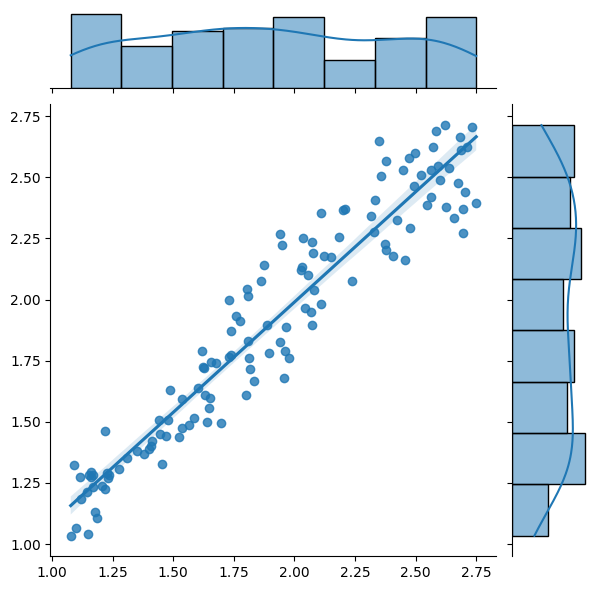

In [ ]:
sns.jointplot(labels[:,0].cpu(),predictions[:,0].cpu().detach(),kind='reg')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


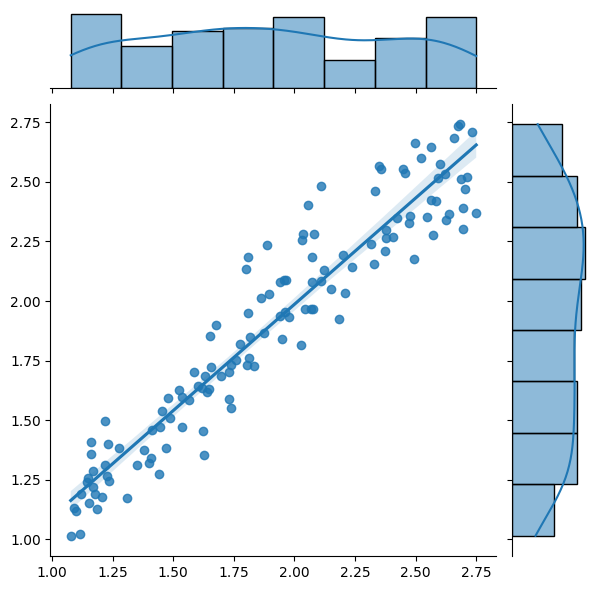

In [ ]:
sns.jointplot(labels[:,0].cpu(),predictions[:,0].cpu().detach(),kind='reg')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


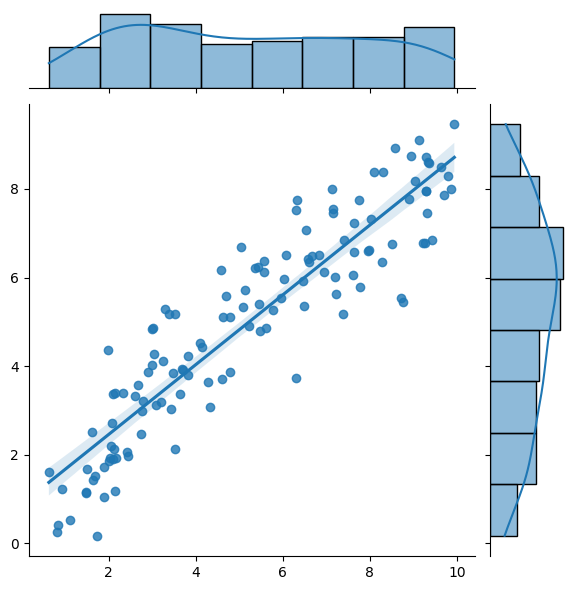

In [ ]:
sns.jointplot(labels[:,1].cpu(),predictions[:,1].cpu().detach(),kind='reg')

In [ ]:
input = None
labels = None
predictions = None


gc.collect()
torch.cuda.empty_cache()

## Fourier sampling (155 years saturation, grid step =1 ). Rename checkpoint to 5 years

In [ ]:
log_dir= Folder+'Neural_Networks/Neural_regression/10_years_Fourier_sampling_05_15_28/VGG_1_1_0_LDE_64/'
learning_rate = 1e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []
# Look what duration or logtau/logrho values initiate high losses. Find how to balance them out?

In [ ]:
# I shouldn't reinitialize the optimizer every time, cause it would forget the moments
optimizer = torch.optim.Adam(
                list(neural_regression.parameters()), lr=learning_rate
            )

In [ ]:
# diagonal softening 1e-6 # no covariance exponents softening
for epoch in range(0,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 16%|█▌        | 200/1250 [02:28<12:43,  1.38it/s]

Iter 200 loss=0.2459 t_cov_loss =0.3453 t_rev_loss = 0.1466, t_cov_mse = 0.2210, t_rev_mse = 0.1451


 32%|███▏      | 400/1250 [04:54<10:33,  1.34it/s]

Iter 400 loss=0.2081 t_cov_loss =0.2924 t_rev_loss = 0.1238, t_cov_mse = 0.1871, t_rev_mse = 0.1226


 48%|████▊     | 600/1250 [07:19<07:51,  1.38it/s]

Iter 600 loss=0.2186 t_cov_loss =0.3094 t_rev_loss = 0.1279, t_cov_mse = 0.1980, t_rev_mse = 0.1266


 64%|██████▍   | 800/1250 [09:44<05:25,  1.38it/s]

Iter 800 loss=0.2082 t_cov_loss =0.2934 t_rev_loss = 0.1231, t_cov_mse = 0.1878, t_rev_mse = 0.1219


 80%|████████  | 1000/1250 [12:08<03:00,  1.38it/s]

Iter 1000 loss=0.2053 t_cov_loss =0.2790 t_rev_loss = 0.1316, t_cov_mse = 0.1786, t_rev_mse = 0.1302


 96%|█████████▌| 1200/1250 [14:33<00:36,  1.38it/s]

Iter 1200 loss=0.1983 t_cov_loss =0.2744 t_rev_loss = 0.1223, t_cov_mse = 0.1756, t_rev_mse = 0.1210


100%|██████████| 156/156 [01:47<00:00,  1.46it/s]


Epoch 1, Train loss 0.2132, Val loss 0.1921 t_cov_loss 0.2529 t_rev_loss 0.1312 t_cov_mse = 0.1619, t_rev_mse = 0.1299


 16%|█▌        | 200/1250 [02:24<12:40,  1.38it/s]

Iter 200 loss=0.2065 t_cov_loss =0.2895 t_rev_loss = 0.1234, t_cov_mse = 0.1853, t_rev_mse = 0.1222


 32%|███▏      | 400/1250 [04:49<10:15,  1.38it/s]

Iter 400 loss=0.1979 t_cov_loss =0.2783 t_rev_loss = 0.1175, t_cov_mse = 0.1781, t_rev_mse = 0.1163


 48%|████▊     | 600/1250 [07:13<07:49,  1.38it/s]

Iter 600 loss=0.2027 t_cov_loss =0.2838 t_rev_loss = 0.1216, t_cov_mse = 0.1816, t_rev_mse = 0.1204


 64%|██████▍   | 800/1250 [09:38<05:25,  1.38it/s]

Iter 800 loss=0.2015 t_cov_loss =0.2847 t_rev_loss = 0.1182, t_cov_mse = 0.1822, t_rev_mse = 0.1171


 80%|████████  | 1000/1250 [12:02<03:00,  1.38it/s]

Iter 1000 loss=0.1991 t_cov_loss =0.2727 t_rev_loss = 0.1254, t_cov_mse = 0.1746, t_rev_mse = 0.1242


 96%|█████████▌| 1200/1250 [14:27<00:36,  1.38it/s]

Iter 1200 loss=0.1922 t_cov_loss =0.2660 t_rev_loss = 0.1184, t_cov_mse = 0.1702, t_rev_mse = 0.1172


100%|██████████| 156/156 [01:45<00:00,  1.48it/s]


Epoch 2, Train loss 0.1993, Val loss 0.1726 t_cov_loss 0.2373 t_rev_loss 0.1079 t_cov_mse = 0.1519, t_rev_mse = 0.1069


 16%|█▌        | 200/1250 [02:24<12:39,  1.38it/s]

Iter 200 loss=0.1865 t_cov_loss =0.2621 t_rev_loss = 0.1109, t_cov_mse = 0.1677, t_rev_mse = 0.1098


 32%|███▏      | 400/1250 [04:50<10:15,  1.38it/s]

Iter 400 loss=0.1824 t_cov_loss =0.2547 t_rev_loss = 0.1102, t_cov_mse = 0.1630, t_rev_mse = 0.1091


 48%|████▊     | 600/1250 [07:15<07:51,  1.38it/s]

Iter 600 loss=0.1875 t_cov_loss =0.2627 t_rev_loss = 0.1123, t_cov_mse = 0.1681, t_rev_mse = 0.1111


 64%|██████▍   | 800/1250 [09:39<05:27,  1.37it/s]

Iter 800 loss=0.1917 t_cov_loss =0.2704 t_rev_loss = 0.1131, t_cov_mse = 0.1731, t_rev_mse = 0.1119


 80%|████████  | 1000/1250 [12:04<03:00,  1.38it/s]

Iter 1000 loss=0.1819 t_cov_loss =0.2487 t_rev_loss = 0.1151, t_cov_mse = 0.1592, t_rev_mse = 0.1139


 96%|█████████▌| 1200/1250 [14:29<00:36,  1.38it/s]

Iter 1200 loss=0.1803 t_cov_loss =0.2490 t_rev_loss = 0.1116, t_cov_mse = 0.1594, t_rev_mse = 0.1105


100%|██████████| 156/156 [01:45<00:00,  1.48it/s]


Epoch 3, Train loss 0.1846, Val loss 0.1713 t_cov_loss 0.2270 t_rev_loss 0.1156 t_cov_mse = 0.1453, t_rev_mse = 0.1144


  2%|▏         | 22/1250 [00:16<14:59,  1.37it/s]


KeyboardInterrupt: ignored

In [ ]:
input,labels = next(iter(test_loader))
input = input.to(device).unsqueeze(1)
labels = labels.to(device)

In [ ]:
predictions = transform_targets_to_labels(neural_regression(input))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


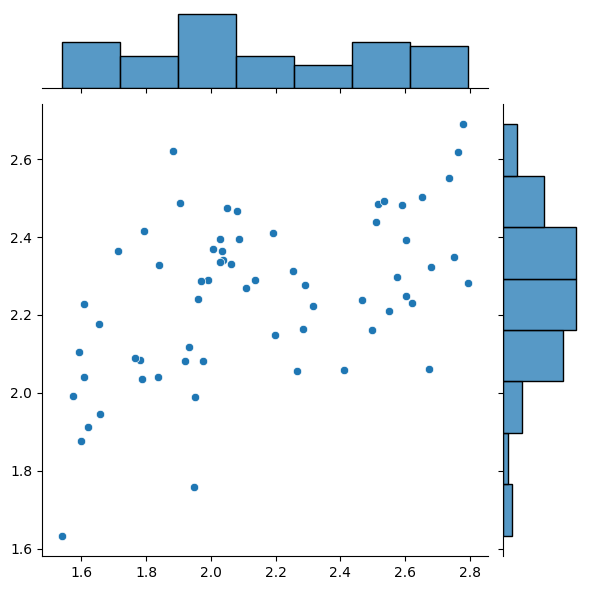

In [ ]:
sns.jointplot(labels[:,0].cpu(),predictions[:,0].cpu().detach())

In [ ]:
# diagonal softening 1e-6
for epoch in range(0,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

  0%|          | 5/1250 [00:15<52:58,  2.55s/it]

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.


  0%|          | 5/1250 [00:20<1:27:04,  4.20s/it]

Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.


FloatingPointError: ignored

In [ ]:
# diagonal softening 1e-6
for epoch in range(0,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 16%|█▌        | 200/1250 [02:44<14:05,  1.24it/s]

Iter 200 loss=0.2997 t_cov_loss =0.2842 t_rev_loss = 0.3151


 32%|███▏      | 400/1250 [05:26<11:26,  1.24it/s]

Iter 400 loss=0.2187 t_cov_loss =0.2566 t_rev_loss = 0.1809


 48%|████▊     | 600/1250 [08:07<08:43,  1.24it/s]

Iter 600 loss=0.2041 t_cov_loss =0.2601 t_rev_loss = 0.1482


 64%|██████▍   | 800/1250 [10:49<06:02,  1.24it/s]

Iter 800 loss=0.2025 t_cov_loss =0.2682 t_rev_loss = 0.1368


 80%|████████  | 1000/1250 [13:30<03:21,  1.24it/s]

Iter 1000 loss=0.1805 t_cov_loss =0.2391 t_rev_loss = 0.1219


 96%|█████████▌| 1200/1250 [16:11<00:40,  1.24it/s]

Iter 1200 loss=0.1702 t_cov_loss =0.2386 t_rev_loss = 0.1018


100%|██████████| 156/156 [02:00<00:00,  1.29it/s]


Epoch 1, Train loss 0.2105 t_cov 0.2274 t_rev 0.0827, Val loss 0.1550


 16%|█▌        | 200/1250 [02:41<14:08,  1.24it/s]

Iter 200 loss=0.1667 t_cov_loss =0.2402 t_rev_loss = 0.0932


 32%|███▏      | 400/1250 [05:22<11:23,  1.24it/s]

Iter 400 loss=0.1590 t_cov_loss =0.2351 t_rev_loss = 0.0829


 48%|████▊     | 600/1250 [08:03<08:42,  1.24it/s]

Iter 600 loss=0.1587 t_cov_loss =0.2465 t_rev_loss = 0.0709


 64%|██████▍   | 800/1250 [10:43<06:02,  1.24it/s]

Iter 800 loss=0.1558 t_cov_loss =0.2438 t_rev_loss = 0.0677


 79%|███████▊  | 984/1250 [13:11<03:34,  1.24it/s]


KeyboardInterrupt: ignored

## Adaptive sampling (length = 3500,error=3.5*1e-3)

In [ ]:
log_dir= Folder+'Neural_Networks/Neural_regression/5_years_adaptive_sampling/VGG_1_1_0_LDE_64/'
learning_rate = 1e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []
# Look what duration or logtau/logrho values initiate high losses. Find how to balance them out?

In [ ]:
# I shouldn't reinitialize the optimizer every time, cause it would forget the moments
optimizer = torch.optim.Adam(
                list(neural_regression.parameters()), lr=learning_rate
            )

In [ ]:
for epoch in range(0,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 16%|█▌        | 200/1250 [04:37<23:46,  1.36s/it]

Iter 200 loss=0.2958 t_cov_loss =0.2861 t_rev_loss = 0.3055


 32%|███▏      | 400/1250 [09:09<19:12,  1.36s/it]

Iter 400 loss=0.2429 t_cov_loss =0.2616 t_rev_loss = 0.2241


 48%|████▊     | 600/1250 [13:40<14:42,  1.36s/it]

Iter 600 loss=0.2221 t_cov_loss =0.2656 t_rev_loss = 0.1787
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.


 48%|████▊     | 600/1250 [13:44<14:53,  1.37s/it]

Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.


FloatingPointError: ignored

In [ ]:
learning_rate = 5e-5
optimizer.param_groups[0]['lr'] = learning_rate

In [ ]:
for epoch in range(5,10):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

In [ ]:
learning_rate = 1e-5
optimizer.param_groups[0]['lr'] = learning_rate

In [ ]:
for epoch in range(10,15):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

## Adaptive sampling (length = 3000,error=4.4*1e-3)

### layers = [1,1,0]. LDE 64

In [ ]:
log_dir= Folder+'Neural_Networks/Neural_regression/5_years_adaptive_sampling/VGG_1_1_0_LDE_64/'
learning_rate = 1e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []
# Look what duration or logtau/logrho values initiate high losses. Find how to balance them out?

In [ ]:
# I shouldn't reinitialize the optimizer every time, cause it would forget the moments
optimizer = torch.optim.Adam(
                list(neural_regression.parameters()), lr=learning_rate
            )

In [ ]:
for epoch in range(0,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 16%|█▌        | 200/1250 [03:45<19:24,  1.11s/it]

Iter 200 loss=0.3220 t_cov_loss =0.3223 t_rev_loss = 0.3217


 32%|███▏      | 400/1250 [07:27<15:40,  1.11s/it]

Iter 400 loss=0.2426 t_cov_loss =0.2580 t_rev_loss = 0.2272


 48%|████▊     | 600/1250 [11:10<12:08,  1.12s/it]

Iter 600 loss=0.2183 t_cov_loss =0.2657 t_rev_loss = 0.1710


 48%|████▊     | 604/1250 [11:15<12:02,  1.12s/it]


KeyboardInterrupt: ignored

In [ ]:
learning_rate = 5e-5
optimizer.param_groups[0]['lr'] = learning_rate

In [ ]:
for epoch in range(5,10):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

In [ ]:
learning_rate = 1e-5
optimizer.param_groups[0]['lr'] = learning_rate

In [ ]:
for epoch in range(10,15):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

In [ ]:
for epoch in range(0,5):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 16%|█▌        | 200/1250 [03:43<19:11,  1.10s/it]

Iter 200 loss=0.2907 t_cov_loss =0.2895 t_rev_loss = 0.2919


 27%|██▋       | 340/1250 [06:16<16:37,  1.10s/it]

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.


 27%|██▋       | 340/1250 [06:21<16:59,  1.12s/it]

Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.


FloatingPointError: ignored

In [ ]:
learning_rate = 5e-5
optimizer.param_groups[0]['lr'] = learning_rate

In [ ]:
for epoch in range(5,10):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

In [ ]:
learning_rate = 1e-5
optimizer.param_groups[0]['lr'] = learning_rate

In [ ]:
for epoch in range(10,15):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

## layers = [1,1,0]. LDE 64

In [ ]:
log_dir= Folder+'Neural_Networks/Neural_regression/checkpoints_5_years/VGG_1_1_0_LDE_64/'
learning_rate = 1e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []
# Look what duration or logtau/logrho values initiate high losses. Find how to balance them out?

In [ ]:
# I shouldn't reinitialize the optimizer every time, cause it would forget the moments
optimizer = torch.optim.Adam(
                list(neural_regression.parameters()), lr=learning_rate
            )

In [ ]:
for epoch in range(0,1):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 16%|█▌        | 200/1250 [02:49<14:25,  1.21it/s]

Iter 200 loss=0.3106 t_cov_loss =0.3241 t_rev_loss = 0.2972


 32%|███▏      | 400/1250 [05:34<11:41,  1.21it/s]

Iter 400 loss=0.2343 t_cov_loss =0.2570 t_rev_loss = 0.2116


 48%|████▊     | 600/1250 [08:19<08:56,  1.21it/s]

Iter 600 loss=0.2123 t_cov_loss =0.2656 t_rev_loss = 0.1591


 64%|██████▍   | 800/1250 [11:04<06:10,  1.21it/s]

Iter 800 loss=0.1990 t_cov_loss =0.2656 t_rev_loss = 0.1323


 80%|████████  | 1000/1250 [13:49<03:26,  1.21it/s]

Iter 1000 loss=0.1851 t_cov_loss =0.2458 t_rev_loss = 0.1244


 96%|█████████▌| 1200/1250 [16:34<00:41,  1.21it/s]

Iter 1200 loss=0.1671 t_cov_loss =0.2429 t_rev_loss = 0.0913


100%|██████████| 156/156 [02:03<00:00,  1.27it/s]


Epoch 1, Train loss 0.2157 t_cov 0.2271 t_rev 0.0648, Val loss 0.1459


In [ ]:
for epoch in range(1,10):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 16%|█▌        | 200/1250 [02:44<14:26,  1.21it/s]

Iter 200 loss=0.1690 t_cov_loss =0.2530 t_rev_loss = 0.0849


 32%|███▏      | 400/1250 [05:29<11:39,  1.22it/s]

Iter 400 loss=0.1558 t_cov_loss =0.2346 t_rev_loss = 0.0769


 48%|████▊     | 600/1250 [08:14<08:53,  1.22it/s]

Iter 600 loss=0.1583 t_cov_loss =0.2499 t_rev_loss = 0.0667


 64%|██████▍   | 800/1250 [10:59<06:10,  1.21it/s]

Iter 800 loss=0.1586 t_cov_loss =0.2551 t_rev_loss = 0.0621


 80%|████████  | 1000/1250 [13:44<03:26,  1.21it/s]

Iter 1000 loss=0.1515 t_cov_loss =0.2303 t_rev_loss = 0.0726


 96%|█████████▌| 1200/1250 [16:29<00:41,  1.20it/s]

Iter 1200 loss=0.1468 t_cov_loss =0.2361 t_rev_loss = 0.0574


100%|██████████| 156/156 [02:01<00:00,  1.29it/s]


Epoch 2, Train loss 0.1560 t_cov 0.2170 t_rev 0.0350, Val loss 0.1260


 16%|█▌        | 200/1250 [02:44<14:29,  1.21it/s]

Iter 200 loss=0.1448 t_cov_loss =0.2362 t_rev_loss = 0.0534


 32%|███▏      | 400/1250 [05:29<11:40,  1.21it/s]

Iter 400 loss=0.1405 t_cov_loss =0.2334 t_rev_loss = 0.0475


 48%|████▊     | 600/1250 [08:14<08:54,  1.21it/s]

Iter 600 loss=0.1441 t_cov_loss =0.2411 t_rev_loss = 0.0471


 64%|██████▍   | 800/1250 [10:59<06:11,  1.21it/s]

Iter 800 loss=0.1486 t_cov_loss =0.2520 t_rev_loss = 0.0452


 80%|████████  | 1000/1250 [13:44<03:25,  1.22it/s]

Iter 1000 loss=0.1400 t_cov_loss =0.2251 t_rev_loss = 0.0549


 96%|█████████▌| 1200/1250 [16:28<00:41,  1.21it/s]

Iter 1200 loss=0.1382 t_cov_loss =0.2307 t_rev_loss = 0.0458


100%|██████████| 156/156 [02:00<00:00,  1.29it/s]


Epoch 3, Train loss 0.1422 t_cov 0.2129 t_rev 0.0339, Val loss 0.1234


 16%|█▌        | 200/1250 [02:44<14:25,  1.21it/s]

Iter 200 loss=0.1388 t_cov_loss =0.2347 t_rev_loss = 0.0429


 32%|███▏      | 400/1250 [05:29<11:42,  1.21it/s]

Iter 400 loss=0.1360 t_cov_loss =0.2308 t_rev_loss = 0.0413


 48%|████▊     | 600/1250 [08:14<08:56,  1.21it/s]

Iter 600 loss=0.1366 t_cov_loss =0.2350 t_rev_loss = 0.0382


 64%|██████▍   | 800/1250 [11:00<06:12,  1.21it/s]

Iter 800 loss=0.1438 t_cov_loss =0.2450 t_rev_loss = 0.0425


 80%|████████  | 1000/1250 [13:47<03:29,  1.19it/s]

Iter 1000 loss=0.1366 t_cov_loss =0.2229 t_rev_loss = 0.0503


 96%|█████████▌| 1200/1250 [16:35<00:42,  1.19it/s]

Iter 1200 loss=0.1365 t_cov_loss =0.2321 t_rev_loss = 0.0409


100%|██████████| 156/156 [02:03<00:00,  1.26it/s]


Epoch 4, Train loss 0.1378 t_cov 0.2244 t_rev 0.0292, Val loss 0.1268


  5%|▍         | 60/1250 [00:50<16:42,  1.19it/s]


KeyboardInterrupt: ignored

In [ ]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%4)

In [ ]:
model_dict = torch.load(log_dir+'%d_epoch.pth'%4)
neural_regression.load_state_dict(model_dict['regressor'])
train_loss_history = model_dict['train_loss_history']
t_cov_history = model_dict['t_cov_history']
t_rev_history = model_dict['t_rev_history']
val_loss_history = model_dict['val_loss_history']
learning_rate = model_dict['lr']
optimizer.load_state_dict(model_dict['optimizer_state_dict'])

In [ ]:
learning_rate = 5e-5
optimizer.param_groups[0]['lr'] = learning_rate

In [ ]:
for epoch in range(4,10):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 16%|█▌        | 200/1250 [02:48<14:44,  1.19it/s]

Iter 200 loss=0.1270 t_cov_loss =0.2233 t_rev_loss = 0.0306


 32%|███▏      | 400/1250 [05:37<11:56,  1.19it/s]

Iter 400 loss=0.1241 t_cov_loss =0.2164 t_rev_loss = 0.0318


 48%|████▊     | 600/1250 [08:25<09:07,  1.19it/s]

Iter 600 loss=0.1262 t_cov_loss =0.2242 t_rev_loss = 0.0283


 64%|██████▍   | 800/1250 [11:14<06:19,  1.19it/s]

Iter 800 loss=0.1304 t_cov_loss =0.2289 t_rev_loss = 0.0319


 80%|████████  | 1000/1250 [14:02<03:31,  1.18it/s]

Iter 1000 loss=0.1282 t_cov_loss =0.2259 t_rev_loss = 0.0304


 96%|█████████▌| 1200/1250 [16:51<00:42,  1.19it/s]

Iter 1200 loss=0.1245 t_cov_loss =0.2208 t_rev_loss = 0.0281


100%|██████████| 156/156 [02:03<00:00,  1.26it/s]


Epoch 5, Train loss 0.1265 t_cov 0.2164 t_rev 0.0215, Val loss 0.1189


  2%|▏         | 22/1250 [00:18<17:26,  1.17it/s]


KeyboardInterrupt: ignored

In [ ]:
input,labels = next(iter(test_loader))
input = input.to(device).unsqueeze(1)
labels = labels.to(device)

In [ ]:
y = neural_regression(input)

In [ ]:
predictions = transform_targets_to_labels(y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


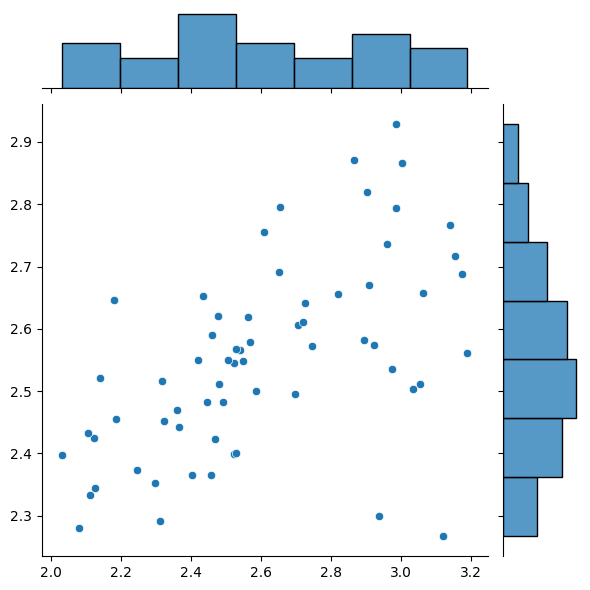

In [ ]:
sns.jointplot(labels[:,0].cpu(),predictions[:,0].cpu().detach())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


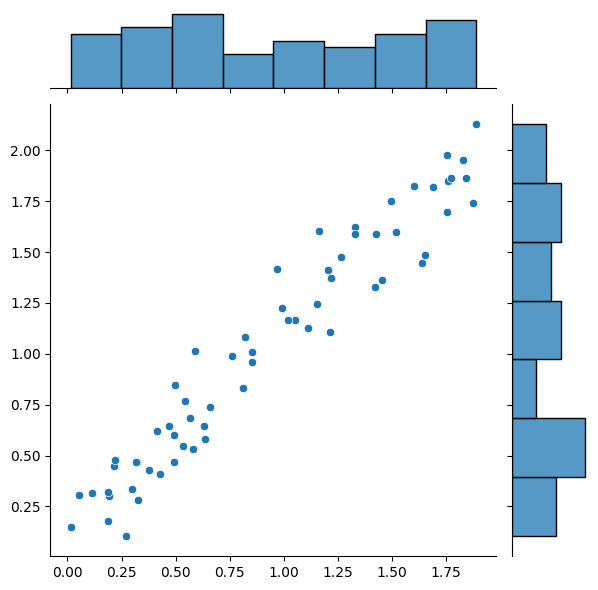

In [ ]:
sns.jointplot(labels[:,1].cpu(),predictions[:,1].cpu().detach())

## layers = [1,1,0]. Conv only

In [ ]:
log_dir= Folder+'Neural_Networks/Neural_regression/checkpoints_5_years/VGG_1_1_0/'
learning_rate = 1e-4

train_loss_history = []
val_loss_history = []
t_cov_history = []
t_rev_history = []
# Look what duration or logtau/logrho values initiate high losses. Find how to balance them out?

In [ ]:
# I shouldn't reinitialize the optimizer every time, cause it would forget the moments
optimizer = torch.optim.Adam(
                list(neural_regression.parameters()), lr=learning_rate
            )

In [ ]:
for epoch in range(0,1):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

  3%|▎         | 38/1250 [00:31<16:49,  1.20it/s]


KeyboardInterrupt: ignored

In [ ]:
for epoch in range(0,1):
  train_epoch(log_dir,neural_regression,
                train_loss_history,val_loss_history,
                t_cov_history,t_rev_history,
                report_iter = 200,epoch_num=epoch+1)

 16%|█▌        | 201/1250 [00:24<02:06,  8.30it/s]

Iter 200 loss=0.2745 t_cov_loss =0.2660 t_rev_loss = 0.2831


 32%|███▏      | 401/1250 [00:49<01:43,  8.18it/s]

Iter 400 loss=0.2350 t_cov_loss =0.2479 t_rev_loss = 0.2221


 48%|████▊     | 601/1250 [01:12<01:17,  8.33it/s]

Iter 600 loss=0.2074 t_cov_loss =0.2409 t_rev_loss = 0.1738


 64%|██████▍   | 801/1250 [01:36<00:54,  8.30it/s]

Iter 800 loss=0.1822 t_cov_loss =0.2412 t_rev_loss = 0.1232


 80%|████████  | 1001/1250 [02:01<00:30,  8.22it/s]

Iter 1000 loss=0.1666 t_cov_loss =0.2322 t_rev_loss = 0.1009


 96%|█████████▌| 1201/1250 [02:25<00:05,  8.36it/s]

Iter 1200 loss=0.1565 t_cov_loss =0.2354 t_rev_loss = 0.0777


100%|██████████| 156/156 [00:17<00:00,  8.71it/s]


Epoch 1, Train loss 0.2016 t_cov 0.2300 t_rev 0.1045, Val loss 0.1672


0.0001

In [ ]:
input,labels = next(iter(test_loader))
input = input.to(device).unsqueeze(1)
labels = labels.to(device)

y = neural_regression(input)
predictions = transform_targets_to_labels(y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


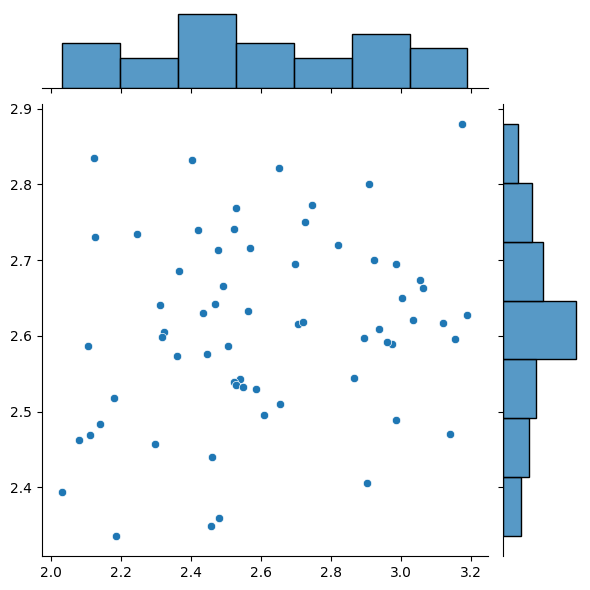

In [ ]:
sns.jointplot(labels[:,0].cpu(),predictions[:,0].cpu().detach())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


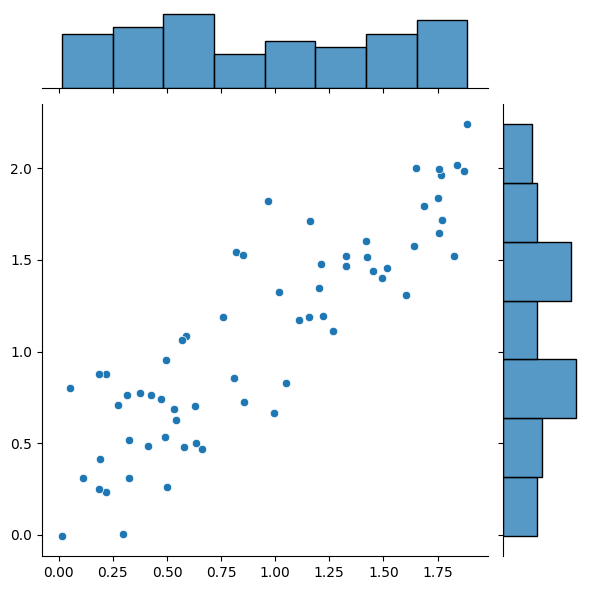

In [ ]:
sns.jointplot(labels[:,1].cpu(),predictions[:,1].cpu().detach())